In [788]:
# Master File for AN-19-154 Work: Search for Neutral Long-lived Particles Decaying in the Muon System

# Coders: Nathan Suri, Caltech; Cristian Pena, Caltech/Fermilab
# Date: July 2019
# LPC LLP Group

# Description
# Compiled progress on AN-19-154 work

# Action Plan
# Add DBSCAN clustering in 3D after punch-through vetoing
# Shift to analyzer ntuples

# Notes/Conclusions
# @nasurijr:

In [789]:
# User specifics
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
    pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    
    # Sets display width
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:85% !important; }</style>"))
    
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username: nasurijr


# Imports

In [790]:
# Imports necessary utilities and modules

import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

# Graph/histo utilities from ROOT
# Contained within the delayed_jet_analyzer repository
import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

# Used for extracting the TTree structure from each datafile
import os
import uproot

# Used for creating user-readable tables
from prettytable import PrettyTable

# Imports jet clustering algorithm (FastJet)
from pyjet import cluster

donotdelete = []

# Read in and Extract TTrees from Datafiles

In [791]:
# Setups dictionaries for storing data from MC/data ntuples
fpath = {}
tree = {}
NEvents = {}

data_path = pwd+'data/'

# Background Samples

# # ggH-comparable background: QCD
# fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'

# # Currently not needed for the analysis
# # Small subset of B samples for quick runs/tests
# fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018B_112_dec.root'
# # Complete set of A and B ZeroBias samples (time-intensive to run)
# fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018AB_complete.root'

# WH-comparable background: WJetsToLNu
# # Small subset of WJetstoLNu (run interactively on jet_timing_studies)
# fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_RunIIFall17DRPremix_WJetsToLNu_TuneCP5_13TeV_setQ5_1.root'

# # Complete set run via CRAB on llp_ntupler (non-extension)
fpath['WJetsToLNu'] = data_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v7.root'

# # Small subset of WJetstoLNu (run interactively on jet_timing_studies)
# fpath['WJetsToLNu'] = data_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v7_chisai.root'


# Contains events that fail punch-through veto and have large nCsc clusters in ME 1/1 and 1/2
# fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_WJetsToLNu_inclusive_punch_test.root'

# Contains events that fail punch-through veto and have large nCsc clusters outside of ME 1/1 and 1/2
# fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_WJetsToLNu_inclusiveNLO_notpunch.root'


################################################################

# Signal Samples

# WH: bbbb
# mH = 125 GeV, mX = 15 GeV, ctau = 10 m
fpath['m15ct10000mm'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-15_ctauS-10000_TuneCUETP8M1_13TeV_v7.root'

# mH = 125 GeV, mX = 40 GeV, ctau = 10 m
fpath['m40ct10000mm'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV_v7.root'

# mH = 125 GeV, mX = 55 GeV, ctau = 10 m, Wminus
fpath['m55ct10000mm_minus'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV_v7.root'
# fpath['m55ct10000mm_minus'] = data_path + 'jet_timing_studies_ntuple_WMinus_mX55ct10m_jetMatch_test.root'

# mH = 125 GeV, mX = 55 GeV, ctau = 10 m, Wplus
fpath['m55ct10000mm_plus'] = data_path + 'WplusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV_v7.root'
# fpath['m55ct10000mm_plus'] = data_path + 'jet_timing_studies_ntuple_Wplus_mX55ct10m_jetMatch_test.root'


# # VH: MET+bb
# # mH = 125 GeV, mX = 50 GeV, ctau = 1 m
# fpath['m50ct1000mm'] = data_path + 'ntuple_RunIISummer16_bbmet_vh_mh125_mx50_pl1000.root'

# # mH = 125 GeV, mX = 50 GeV, ctau = 10 m
# fpath['m50ct10000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh125_mx50_pl10000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
# fpath['m975ct1000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh2000_mx975_pl1000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
# fpath['m975ct10000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh2000_mx975_pl10000.root'

# ggH
# mH = 125 GeV, mX = 50 GeV, ctau = 1 m
# fpath['m50ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# # mH = 125 GeV, mX = 50 GeV, ctau = 10 m
# fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
# fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
# fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

# Iterates through each file and extracts the ROOT TTree structure from each
for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
    # Accesses the array form of the jetPt branch
#     a = tree[k]["jetPt"].array()
#     print(a[:-1][0])

2019-08-30 13:51:39.070632-07:00
WJetsToLNu /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v7.root
2019-08-30 13:51:49.724634-07:00
m15ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-15_ctauS-10000_TuneCUETP8M1_13TeV_v7.root
2019-08-30 13:51:50.379884-07:00
m40ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV_v7.root
2019-08-30 13:51:51.039778-07:00
m55ct10000mm_minus /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV_v7.root
2019-08-30 13:51:51.512377-07:00
m55ct10000mm_plus /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WplusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV_v7.root


## Name TTree Objects

In [792]:
# Bookkeeping: Defines the TTrees from the read datafiles
# Names displayed in README.md table

T_m15_ct10 = tree['m15ct10000mm']
T_wjets = tree['WJetsToLNu']
T_m40_ct10 = tree['m40ct10000mm']
T_m55_ct10_minus = tree['m55ct10000mm_minus']
T_m55_ct10_plus = tree['m55ct10000mm_plus']

# Define Variables and Name Datafiles 

In [793]:
# Variable Definitions
# Creates dictionaries for variables to be analyzed
# The dictionaries will contain the variable arrays for each datafile with a relevant key

# Boolean selections
sel_bool = {}

# CSC
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
csc_t = {}
csc_r = {}

# Gen Level
# gLLP_eta = {}
gLLP_r_0 = {}
gLLP_r_1 = {}
gLLP_decay_0 = {}
gLLP_decay_1 = {}

# Reco level
met_pt = {}
eventNum = {}
lumiNum = {}
jet_pt = {}
ele_pt = {}
mu_pt = {}
nJets = {}
nElectrons = {}
nMuons = {}
nRechits_flag = {}

# Reco - jets
jetEta = {}
jetPhi = {}

In [794]:
# Bookkeeping: Creates a dictionary for iterating over all of the datafiles and 
#              converting the relevant branches to numpy arrays
# Names displayed in README.md table

# data_trees = {'m55ct10m_wh_bbbb_minus': T_m55_ct10_minus, 'm55ct10m_wh_bbbb_plus': T_m55_ct10_plus, 'WJetsToLNu': T_wjets, 'm15ct10000mm': T_m15_ct10}

data_trees = {'m55ct10m_wh_bbbb_minus': T_m55_ct10_minus, 'm55ct10m_wh_bbbb_plus': T_m55_ct10_plus, 'WJetsToLNu': T_wjets}

# Event Selection

## TBranch -> np.array() Conversion

In [795]:
# Event Selection

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species, arbor in data_trees.items():
    if 'wh' in species:
        ele_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 13, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
        mu_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 11, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
        sel_lepton = []
        time_counter = 0
        
        # To look at both muon/electron channels
#         for ev in np.logical_or(ele_sel, mu_sel):
        # For electron-only channel
#         for ev in ele_sel:
#             time_counter += 1
#             if (time_counter % 100000) == 0:
#                 print(str(time_counter) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
#             if ev.any():
#                 sel_lepton.append(True)
#             else:
#                 sel_lepton.append(False)
        sel_lepton = np.ones(len(arbor), dtype=bool)      
    if 'wh' not in species:
        sel_lepton = np.ones(len(arbor), dtype=bool)
                
    if 'metbb' in species or 'bbmet' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_decay_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2 + (arbor['gLLP_decay_vertex_z'].array()[:,0])**2)

        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
        
        sel_signal = np.logical_and(sel_dis_1, sel_lepton)
        sel_bool[species] = sel_signal 
        
    if 'bbbb' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_r_1[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,1])**2+(arbor['gLLP_decay_vertex_y'].array()[:,1])**2)

        
        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
        
        sel_dis_1 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) < 1100)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])<2.4)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])>0.9)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(gLLP_r_1[species])<695.5)
        
        sel_signal = np.logical_or(sel_dis_0, sel_dis_1)
        sel_signal = np.logical_and(sel_signal, sel_lepton)
        sel_bool[species] = sel_signal 
        
    else:
        sel_bool[species] = np.ones(len(arbor['nCsc'].array()), dtype=bool)
        
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-30 13:51:53.882572-07:00
m55ct10m_wh_bbbb_minus: 2019-08-30 13:51:55.961297-07:00
m55ct10m_wh_bbbb_plus: 2019-08-30 13:51:58.394569-07:00
WJetsToLNu: 2019-08-30 13:52:46.885517-07:00


In [796]:
# Application of event selection to variables

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

csc_r_quad = {}
for species, arbor in data_trees.items():
    # Endcap: CSCs
    nCsc[species] = arbor['nCsc'].array()#[sel_bool[species]]
    csc_z[species] = arbor['cscZ'].array()#[sel_bool[species]]
    csc_x[species] = arbor['cscX'].array()#[sel_bool[species]]
    csc_y[species] = arbor['cscY'].array()#[sel_bool[species]]
    csc_t[species] = arbor['cscT'].array()#[sel_bool[species]]
    csc_eta[species] = arbor['cscEta'].array()#[sel_bool[species]]
    csc_phi[species] = arbor['cscPhi'].array()#[sel_bool[species]]
#     csc_r_quad[species] = np.array(arbor['cscX'].array()[sel_bool[species]])**2 + np.array(arbor['cscY'].array()[sel_bool[species]])**2
    csc_r_quad[species] = np.array(arbor['cscX'].array())**2 + np.array(arbor['cscY'].array())**2
    csc_r[species] = []
    for hit_r in csc_r_quad[species]:
        r_val = np.sqrt(hit_r.astype(float))
        csc_r[species].append(r_val)

    # Reco-level
    eventNum[species] = arbor['eventNum'].array()#[sel_bool[species]]
    lumiNum[species] = arbor['lumiNum'].array()#[sel_bool[species]]
#     met_pt[species] = arbor['metType1Pt'].array()[sel_bool[species]]
    
    jet_pt[species] = arbor['jetPt'].array()#[sel_bool[species]]
#     ele_pt[species] = arbor['elePt'].array()[sel_bool[species]]
#     mu_pt[species] = arbor['muonPt'].array()[sel_bool[species]]
    nJets[species] = arbor['nJets'].array()#[sel_bool[species]]
#     nElectrons[species] = arbor['nElectrons'].array()[sel_bool[species]]
#     nMuons[species] = arbor['nMuons'].array()[sel_bool[species]]
#     if species not in ('ggH', 'zeroBias', 'qcd'):
    nRechits_flag[species] = (arbor['cscNRecHits_flag'].array())#[sel_bool[species]]

    
    
    jetEta[species] = arbor['jetEta'].array()#[sel_bool[species]]
    jetPhi[species] = arbor['jetPhi'].array()#[sel_bool[species]]
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-30 13:52:46.932037-07:00
m55ct10m_wh_bbbb_minus: 2019-08-30 13:52:57.714909-07:00
m55ct10m_wh_bbbb_plus: 2019-08-30 13:52:58.525611-07:00


KeyboardInterrupt: 

In [ ]:
# # Creates a 1D histogram for the number of CSC hits for the m55ct10m signal MC and WJetsToLNu MC

# c = rt.TCanvas('c','c', 800, 600)
# h = {}

# h['gLLP_z'] = create_TH1D(T_m55_ct10_minus['gLLP_decay_vertex_x'].array()[:,0], axis_title=['m55ct10m_wh_bbbb_minus', 'Events'], name='m55ct10m_wh_bbbb_minus', binning=[150,-1100,1100])
# h['gLLP_z'].SetLineColor(4)

# h['gLLP_z_cut'] = create_TH1D(T_m55_ct10_minus['gLLP_decay_vertex_x'].array()[:,0][sel_bool['m55ct10m_wh_bbbb_minus']], axis_title=['m55ct10m_wh_bbbb_prime', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,-1100,1100])
# h['gLLP_z_cut'].SetLineColor(2)


# c.SetLogy()

# h['gLLP_z'].SetLineWidth(2)
# h['gLLP_z_cut'].SetLineWidth(2)

# h['gLLP_z'].GetXaxis().SetRangeUser(-1100,1100)


# h['gLLP_z'].SetStats(0)
# h['gLLP_z'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
# h['gLLP_z'].SetXTitle("gLLP_decay_vertex_z")


# h['gLLP_z'].Draw('histo')
# h['gLLP_z_cut'].Draw('histo+same')
# # h['gLLP_z'].Draw('histo+same')


# legend = rt.TLegend(0.6,0.80,0.7,0.7);
# legend.SetTextSize(0.04);
# legend.SetBorderSize(0);
# legend.AddEntry( h['gLLP_z'], "WminusH w/o cut" , "L");
# legend.AddEntry( h['gLLP_z_cut'], "WminusH with cut" , "L");

# legend.Draw();

# c.Draw()

In [ ]:
# # Auxiliary variables for investigating jets(/muons/electrons: deprecated)

# lead_jet_pt = {}
# max_jet_pt = {}
# avg_jet_pt = {}

# # lead_mu_pt = {}
# # max_mu_pt = {}
# # avg_mu_pt = {}

# # lead_ele_pt = {}
# # max_ele_pt = {}
# # avg_ele_pt = {}

# for species in data_trees.keys():
#     lead_jet_pt[species] = [x[0] if len(x) else -1 for x in jet_pt[species]]
#     max_jet_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in jet_pt[species]]
#     avg_jet_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in jet_pt[species]]
    
# #     lead_mu_pt[species] = [x[0] if len(x) else -1 for x in mu_pt[species]]
# #     max_mu_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in mu_pt[species]]
# #     avg_mu_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in mu_pt[species]]
    
# #     lead_ele_pt[species] = [x[0] if len(x) else -1 for x in ele_pt[species]]
# #     max_ele_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in ele_pt[species]]
# #     avg_ele_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in ele_pt[species]]
    
#     print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [ ]:
# Endcap: CSCs
nCsc['m55ct10m_wh_bbbb'] = np.concatenate([nCsc['m55ct10m_wh_bbbb_minus'], nCsc['m55ct10m_wh_bbbb_plus']])
csc_z['m55ct10m_wh_bbbb'] = np.concatenate([csc_z['m55ct10m_wh_bbbb_minus'], csc_z['m55ct10m_wh_bbbb_plus']])
csc_x['m55ct10m_wh_bbbb'] = np.concatenate([csc_x['m55ct10m_wh_bbbb_minus'], csc_x['m55ct10m_wh_bbbb_plus']])
csc_y['m55ct10m_wh_bbbb'] = np.concatenate([csc_y['m55ct10m_wh_bbbb_minus'], csc_y['m55ct10m_wh_bbbb_plus']])
csc_t['m55ct10m_wh_bbbb'] = np.concatenate([csc_t['m55ct10m_wh_bbbb_minus'], csc_t['m55ct10m_wh_bbbb_plus']])
csc_eta['m55ct10m_wh_bbbb'] = np.concatenate([csc_eta['m55ct10m_wh_bbbb_minus'], csc_eta['m55ct10m_wh_bbbb_plus']])
csc_phi['m55ct10m_wh_bbbb'] = np.concatenate([csc_phi['m55ct10m_wh_bbbb_minus'], csc_phi['m55ct10m_wh_bbbb_plus']])
csc_r['m55ct10m_wh_bbbb'] = np.concatenate([csc_r['m55ct10m_wh_bbbb_minus'], csc_r['m55ct10m_wh_bbbb_plus']])


# Reco-level
eventNum['m55ct10m_wh_bbbb'] = np.concatenate([eventNum['m55ct10m_wh_bbbb_minus'], eventNum['m55ct10m_wh_bbbb_plus']])
lumiNum['m55ct10m_wh_bbbb'] = np.concatenate([lumiNum['m55ct10m_wh_bbbb_minus'], lumiNum['m55ct10m_wh_bbbb_plus']])
# met_pt['m55ct10m_wh_bbbb'] = np.concatenate([met_pt['m55ct10m_wh_bbbb_minus'], met_pt['m55ct10m_wh_bbbb_plus']])

jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([jet_pt['m55ct10m_wh_bbbb_minus'], jet_pt['m55ct10m_wh_bbbb_plus']])
# ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([ele_pt['m55ct10m_wh_bbbb_minus'], ele_pt['m55ct10m_wh_bbbb_plus']])
# mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([mu_pt['m55ct10m_wh_bbbb_minus'], mu_pt['m55ct10m_wh_bbbb_plus']])
nJets['m55ct10m_wh_bbbb'] = np.concatenate([nJets['m55ct10m_wh_bbbb_minus'], nJets['m55ct10m_wh_bbbb_plus']])
# nElectrons['m55ct10m_wh_bbbb'] = np.concatenate([nElectrons['m55ct10m_wh_bbbb_minus'], nElectrons['m55ct10m_wh_bbbb_plus']])
# nMuons['m55ct10m_wh_bbbb'] = np.concatenate([nMuons['m55ct10m_wh_bbbb_minus'], nMuons['m55ct10m_wh_bbbb_plus']])
nRechits_flag['m55ct10m_wh_bbbb'] = np.concatenate([nRechits_flag['m55ct10m_wh_bbbb_minus'], nRechits_flag['m55ct10m_wh_bbbb_plus']])


jetEta['m55ct10m_wh_bbbb'] = np.concatenate([jetEta['m55ct10m_wh_bbbb_minus'], jetEta['m55ct10m_wh_bbbb_plus']])
jetPhi['m55ct10m_wh_bbbb'] = np.concatenate([jetPhi['m55ct10m_wh_bbbb_minus'], jetPhi['m55ct10m_wh_bbbb_plus']])

# Auxiliary
# lead_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_jet_pt['m55ct10m_wh_bbbb_minus'], lead_jet_pt['m55ct10m_wh_bbbb_plus']])
# max_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_jet_pt['m55ct10m_wh_bbbb_minus'], max_jet_pt['m55ct10m_wh_bbbb_plus']])
# avg_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_jet_pt['m55ct10m_wh_bbbb_minus'], avg_jet_pt['m55ct10m_wh_bbbb_plus']])

# lead_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_mu_pt['m55ct10m_wh_bbbb_minus'], lead_mu_pt['m55ct10m_wh_bbbb_plus']])
# max_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_mu_pt['m55ct10m_wh_bbbb_minus'], max_mu_pt['m55ct10m_wh_bbbb_plus']])
# avg_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_mu_pt['m55ct10m_wh_bbbb_minus'], avg_mu_pt['m55ct10m_wh_bbbb_plus']])

# lead_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_ele_pt['m55ct10m_wh_bbbb_minus'], lead_ele_pt['m55ct10m_wh_bbbb_plus']])
# max_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_ele_pt['m55ct10m_wh_bbbb_minus'], max_ele_pt['m55ct10m_wh_bbbb_plus']])
# avg_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_ele_pt['m55ct10m_wh_bbbb_minus'], avg_ele_pt['m55ct10m_wh_bbbb_plus']])

## Weight Calculation (Currently 100% BR for WH)

In [ ]:
weight_m55ct10m_minus = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_minus']
weight_m55ct10m_minus = np.full(len(nCsc['m55ct10m_wh_bbbb_minus']), weight_m55ct10m_minus)


weight_m55ct10m_plus = (8.4 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_plus']
weight_m55ct10m_plus = np.full(len(nCsc['m55ct10m_wh_bbbb_plus']), weight_m55ct10m_plus)

weight_m55ct10m = np.concatenate([weight_m55ct10m_minus, weight_m55ct10m_plus])

# weight_m15ct10m = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m15ct10000mm']
# weight_m15ct10m = np.full(len(nCsc['m15ct10m_wh_bbbb']), weight_m15ct10m)

# weight_m40ct10m = (61526.7 * 137 * 1000)/NEvents['m40ct10000mm']
# weight_m40ct10m = np.full(len(nCsc['m40ct10m_wh_bbbb']), weight_m40ct10m)

weight_WJetsToLNu = (61526.7 * 137 * 1000)/NEvents['WJetsToLNu']
weight_WJetsToLNu = np.full(len(nCsc['WJetsToLNu']), weight_WJetsToLNu)

# Baseline/Out-of-the-box plot of WH, WJetsToLNu N<sub>CSC<sub>

In [ ]:
# nCsc_gen = {}
# nCsc_gen['m55ct10m_wh_bbbb'] = np.concatenate([T_m55_ct10_minus['nCsc'].array(), T_m55_ct10_plus['nCsc'].array()])
# nCsc_gen['m55ct10m_wh_bbbb_minus'] = T_m55_ct10_minus['nCsc'].array()
# nCsc_gen['m55ct10m_wh_bbbb_plus'] = T_m55_ct10_plus['nCsc'].array()
# nCsc_gen['WJetsToLNu'] = T_wjets['nCsc'].array()

# weight_m55ct10m_minus_gen = np.full(len(T_m55_ct10_minus['nCsc'].array()), weight_m55ct10m_minus[0])
# weight_m55ct10m_plus_gen = np.full(len(T_m55_ct10_plus['nCsc'].array()), weight_m55ct10m_plus[0])
# weight_m55ct10m_gen = np.concatenate([weight_m55ct10m_minus_gen, weight_m55ct10m_plus_gen])

# weight_WJetsToLNu_gen = np.full(len(nCsc_gen['WJetsToLNu']), weight_WJetsToLNu[0])

In [ ]:
# Creates a 1D histogram for the number of CSC hits for the m55ct10m signal MC and WJetsToLNu MC

c = rt.TCanvas('c','c', 800, 600)
h = {}

h['m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb'].SetLineColor(4)

h['nCsc_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets'].SetLineColor(2)
h['nCsc_wjets'].SetLineStyle(1)

h['sig_before_cut'] = create_TH1D(nCsc_gen['m55ct10m_wh_bbbb'], axis_title=['sig_before_cut', 'Events'], name='sig_before_cut', binning=[150,0,500], weights = weight_m55ct10m_gen)
h['sig_before_cut'].SetLineColor(4)
h['sig_before_cut'].SetLineStyle(2)

h['bkg_before_cut'] = create_TH1D(nCsc_gen['WJetsToLNu'], axis_title=['bkg_before_cut', 'Events'], name='bkg_before_cut', binning=[150,0,500], weights = weight_WJetsToLNu_gen)
h['bkg_before_cut'].SetLineColor(2)
h['bkg_before_cut'].SetLineStyle(2)


c.SetLogy()

h['m55ct10m_wh_bbbb'].SetLineWidth(2)

h['nCsc_wjets'].SetLineWidth(2)
h['sig_before_cut'].SetLineWidth(2)
h['bkg_before_cut'].SetLineWidth(2)


h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**10)

h['nCsc_wjets'].GetXaxis().SetRangeUser(0,400)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['nCsc_wjets'].SetXTitle("N_{csc}")


h['nCsc_wjets'].Draw('histo')
h['m55ct10m_wh_bbbb'].Draw('histo+same')
h['sig_before_cut'].Draw('histo+same')
h['bkg_before_cut'].Draw('histo+same')


legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['nCsc_wjets'], "WJetsToLNu (MC)" , "L");
legend.AddEntry( h['sig_before_cut'], "mX=55 GeV, c#tau=10m (Gen)" , "L");
legend.AddEntry( h['bkg_before_cut'], "WJetsToLNu (Gen)" , "L");

legend.Draw();

c.Draw()

# ncsc_inclusive_mc_wh = rt.TFile('ncsc_inclusive_mc_wh.root', "RECREATE");
# h.Write("m55ct10m_wh_bbbb");
# h['nCsc_wjets'].Write("bkg_ncsc_inclusive");
# tree.SetBranchStatus("*",1);
# newTTree = rt.TTree;
# NEvents.Write("NEvents")
# newTree.Write();


# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

## Strategy I: Simple Hit Removal based on CSC Station

### Algorithm

In [ ]:
# Hit Removal
# For both the endcap and barrel regions (overlap to be determined), the closest stations to the beamspot are the noisiest.
# Thus, we remove the hits that land in these stations for each event in each datafile.

# Endcap
nCsc_station = {}
nCsc_removal = {}
cscEta_removal = {}
cscPhi_removal = {}

# Loops over every datafile
for files in data_trees.keys():
    # Endcap
    nCsc_station[files] = {}
    nCsc_station[files]['ME_11'] = []
    nCsc_station[files]['ME_12'] = []
    nCsc_station[files]['ME_13'] = []
    
    cscEta_removal[files] = {}
    cscEta_removal[files]['ME_11'] = []
    cscEta_removal[files]['ME_12'] = []
    cscEta_removal[files]['ME_13'] = []
    
    cscPhi_removal[files] = {}
    cscPhi_removal[files]['ME_11'] = []
    cscPhi_removal[files]['ME_12'] = []
    cscPhi_removal[files]['ME_13'] = []
    
    # Loops over every event in each datafile
    for pos_bool in range(len(csc_z[files])):
        csc_r = np.sqrt(csc_x[files][pos_bool]**2+csc_y[files][pos_bool]**2)
        z_pos_bool = csc_z[files][pos_bool]
        
        eta_11 = np.copy(csc_eta[files][pos_bool])
        phi_11 = np.copy(csc_phi[files][pos_bool])
        
        eta_12 = np.copy(csc_eta[files][pos_bool])
        phi_12 = np.copy(csc_phi[files][pos_bool])
        
        eta_13 = np.copy(csc_eta[files][pos_bool])
        phi_13 = np.copy(csc_phi[files][pos_bool])
        
        counter_me11 = 0
        counter_me12 = 0
        counter_me13 = 0
        
        # Loops over every hit in each event
        for z_ind in range(len(z_pos_bool)):
#             phi_event_11 = phi_pos_bool
#             eta_event_11 = eta_pos_bool
            
#             phi_event_12 = np.copy(phi_pos_bool)
#             eta_event_12 = eta_pos_bool
            
#             phi_event_13 = phi_pos_bool
#             eta_event_13 = eta_pos_bool
            
            z_bool = np.absolute(z_pos_bool[z_ind])
            # ME 1/1 Constraints
            if z_bool > 568 and z_bool < 632:
                counter_me11 += 1
                phi_11[z_ind] = 0
                eta_11[z_ind] = 0
                
            if z_bool > 663 and z_bool < 724:
                # ME 1/2 Constraints
                if csc_r[z_ind] < 465 and csc_r[z_ind] > 275:
                    counter_me12 += 1
                    phi_12[z_ind] = 0
                    eta_12[z_ind] = 0

                # ME 1/3 Constraints
                if csc_r[z_ind] < 695.5 and csc_r[z_ind] > 505.5:
                    counter_me13 += 1
                    phi_13[z_ind] = 0
                    eta_13[z_ind] = 0

        
        
#         print(len(csc_phi['m55ct10m_wh_bbbb'][0][np.logical_and(phi_11 != 0, phi_12 != 0)]))
#         print(len(csc_phi['m55ct10m_wh_bbbb'][0][phi_12 != 0]))
        
#         print(phi_11)
    
    
        nCsc_station[files]['ME_11'].append(counter_me11)
        nCsc_station[files]['ME_12'].append(counter_me12)
        nCsc_station[files]['ME_13'].append(counter_me13)
        
        cscPhi_removal[files]['ME_11'].append(csc_phi[files][pos_bool][phi_11 != 0])
        cscPhi_removal[files]['ME_12'].append(csc_phi[files][pos_bool][np.logical_and(phi_11 != 0, phi_12 != 0)])
#         cscPhi_removal[files]['ME_13'].append(phi_event_13)
        
        cscEta_removal[files]['ME_11'].append(csc_eta[files][pos_bool][eta_11 != 0])
        cscEta_removal[files]['ME_12'].append(csc_eta[files][pos_bool][np.logical_and(eta_11 != 0, eta_12 != 0)])
#         cscEta_removal[files]['ME_13'].append(eta_event_13)
            
    
    # nCsc dictionaries containing hits removed labelled by removed stations
    nCsc_removal[files] = {}
    nCsc_removal[files]['ME_11'] = np.array(nCsc[files]) - np.array(nCsc_station[files]['ME_11'])
    nCsc_removal[files]['ME_112'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']))
    nCsc_removal[files]['ME_1123'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']) + np.array(nCsc_station[files]['ME_13']))
    
    print(files + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### *Combination of Variables for WH Signal Sample*

In [ ]:
nCsc_removal['m55ct10m_wh_bbbb'] = {}
nCsc_removal['m55ct10m_wh_bbbb']['ME_11'] = np.concatenate([nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_11'], nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_11']])
nCsc_removal['m55ct10m_wh_bbbb']['ME_112'] = np.concatenate([nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_112'], nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_112']])

cscEta_removal['m55ct10m_wh_bbbb'] = {}
cscEta_removal['m55ct10m_wh_bbbb']['ME_11'] = np.concatenate([cscEta_removal['m55ct10m_wh_bbbb_minus']['ME_11'], cscEta_removal['m55ct10m_wh_bbbb_plus']['ME_11']])
cscEta_removal['m55ct10m_wh_bbbb']['ME_12'] = np.concatenate([cscEta_removal['m55ct10m_wh_bbbb_minus']['ME_12'], cscEta_removal['m55ct10m_wh_bbbb_plus']['ME_12']])

cscPhi_removal['m55ct10m_wh_bbbb'] = {}
cscPhi_removal['m55ct10m_wh_bbbb']['ME_11'] = np.concatenate([cscPhi_removal['m55ct10m_wh_bbbb_minus']['ME_11'], cscPhi_removal['m55ct10m_wh_bbbb_plus']['ME_11']])
cscPhi_removal['m55ct10m_wh_bbbb']['ME_12'] = np.concatenate([cscPhi_removal['m55ct10m_wh_bbbb_minus']['ME_12'], cscPhi_removal['m55ct10m_wh_bbbb_plus']['ME_12']])

### Comparison Histogram between Baseline and Strategy I

In [ ]:
# Creates a comparative 1D histogram for the number of CSC hits for the m55ct10m signal MC and WJetsToLNu MC between the baseline and simple hit removal

c_1 = rt.TCanvas('c','c', 800, 600)

h['m55ct10m_wh_bbbb_inc'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb_inc'].SetLineColor(4)

h['m55ct10m_wh_bbbb_no112'] = create_TH1D(nCsc_removal['m55ct10m_wh_bbbb']['ME_112'], axis_title=['m55ct10m_wh_bbbb_no112', 'Events'], name='m55ct10m_wh_bbbb_no112', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb_no112'].SetLineColor(4)
h['m55ct10m_wh_bbbb_no112'].SetLineStyle(2)

h['nCsc_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets'].SetLineColor(2)

h['nCsc_wjets_no112'] = create_TH1D(nCsc_removal['WJetsToLNu']['ME_112'], axis_title=['nCsc_wjets_no112', 'Events'], name='nCsc_wjets_no112', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets_no112'].SetLineColor(2)
h['nCsc_wjets_no112'].SetLineStyle(2)


c_1.SetLogy()

# h['m55ct10m_wh_bbbb'].Scale(1.0/h['m55ct10m_wh_bbbb'].Integral())
# h['nCsc_wjets'].Scale(1.0/h['nCsc_wjets'].Integral())


h['m55ct10m_wh_bbbb_inc'].SetLineWidth(2)
h['m55ct10m_wh_bbbb_no112'].SetLineWidth(2)


h['nCsc_wjets'].SetLineWidth(2)
h['nCsc_wjets_no112'].SetLineWidth(2)

h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**10)
h['nCsc_wjets'].GetXaxis().SetRangeUser(0,300)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("(WH #rightarrow bbbb)")
h['nCsc_wjets'].SetXTitle("N_{csc}")


h['nCsc_wjets'].Draw('histo')
h['m55ct10m_wh_bbbb_no112'].Draw('histo+same')
h['m55ct10m_wh_bbbb_inc'].Draw('histo+same')
h['nCsc_wjets_no112'].Draw('histo+same')

legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetHeader("137 fb^{-1}")
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
# legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb_inc'], "Signal" , "L");
legend.AddEntry( h['nCsc_wjets'], "Bkg" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb_no112'], "Signal w/o ME 1/1, 1/2" , "L");
legend.AddEntry( h['nCsc_wjets_no112'], "Bkg w/o ME 1/1, 1/2" , "L");


legend.Draw();

c_1.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

In [ ]:
print(np.sum(weight_m55ct10m_minus[nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_112']>135])+np.sum(weight_m55ct10m_plus[nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_112']>135]))
print(np.sum(weight_WJetsToLNu[nCsc_removal['WJetsToLNu']['ME_112']>135]))

# for x in range(300):
#     while np.sum(weight_m55ct10m_minus[nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_112']>x])+np.sum(weight_m55ct10m_plus[nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_112']>x]) > 10:
#         continue
#     print(x)

### Comparison of Strategy I to Baseline via N<sub>CSC</sub> Threshold ROC Curves

### *Calculation*

In [ ]:
# ROC Curve for WH/WJetsToLNu Samples: nCsc 

eff_ncsc = {}
rejection_power = {}
ncsc_var_x = np.array([])

for data_type in data_trees.keys():
    eff_ncsc[data_type] = {}
    
    eff_ncsc[data_type]['noCluster'] = {}
    eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.array([])
    
    for hit_thresh in range(0, 200):
        ncsc_var_x = np.append(ncsc_var_x, hit_thresh)

       # Baseline ROCs
        eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['noCluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc[data_type])>hit_thresh)/len(nCsc[data_type]))
        eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_11'])>hit_thresh)/len(nCsc_removal[data_type]['ME_11']))
        eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_112'])>hit_thresh)/len(nCsc_removal[data_type]['ME_112']))
        eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_1123'])>hit_thresh)/len(nCsc_removal[data_type]['ME_1123']))
     
        
    # Rejection power calculation
    rejection_power[data_type] = {}
    rejection_power[data_type]['noCluster'] = {}
    
    # No clustering
    rejection_power[data_type]['noCluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_inclusive']))
    rejection_power[data_type]['noCluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME11']))
    rejection_power[data_type]['noCluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME112']))
    rejection_power[data_type]['noCluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME1123']))
    
    print(data_type + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### *Combination of Efficiencies/Rejection Powers for WH Signal Sample*

In [ ]:
eff_ncsc['m55ct10m_wh_bbbb'] = {}
for llave in eff_ncsc['m55ct10m_wh_bbbb_minus'].keys():
    eff_ncsc['m55ct10m_wh_bbbb'][llave] = {}
    for cle in eff_ncsc['m55ct10m_wh_bbbb_minus'][llave].keys():
        eff_ncsc['m55ct10m_wh_bbbb'][llave][cle] = np.concatenate([eff_ncsc['m55ct10m_wh_bbbb_minus'][llave][cle], eff_ncsc['m55ct10m_wh_bbbb_plus'][llave][cle]])

### *ROC Curve Plot*

In [ ]:
# Creates ROC curves for the signal efficiency of the m55ct10m signal sample against the WJetsToLNu samples using nCsc thresholds comparing baseline with Strategy I

c_roc1 = rt.TCanvas('c_roc1','c_roc1', 800, 600)

h['roc_curve_baseline'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_inclusive'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_no11'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME11'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_no112'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME112'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_no113'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME1123'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME1123'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])


c_roc1.SetLogx()

h['roc_curve_baseline'].SetTitle('WJetsToLNu')


h['roc_curve_baseline'].SetLineWidth(2)
h['roc_curve_no11'].SetLineWidth(2)
h['roc_curve_no112'].SetLineWidth(2)
h['roc_curve_no113'].SetLineWidth(2)


h['roc_curve_baseline'].SetLineColor(1)
h['roc_curve_baseline'].SetLineStyle(2)

h['roc_curve_no11'].SetLineColor(2)
h['roc_curve_no11'].SetLineStyle(2)

h['roc_curve_no112'].SetLineColor(4)
h['roc_curve_no112'].SetLineStyle(2)

h['roc_curve_no113'].SetLineColor(3)
h['roc_curve_no113'].SetLineStyle(2)

h['roc_curve_baseline'].GetXaxis().SetLimits(10, 10**7)
h['roc_curve_baseline'].GetYaxis().SetRangeUser(0,1)

h['roc_curve_baseline'].Draw()
h['roc_curve_no11'].Draw('same')

h['roc_curve_no112'].Draw('same')
# h['roc_curve_no113'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_baseline'], "Inclusive", 'l');
legend.AddEntry( h['roc_curve_no11'], "No 1/1", 'l');
legend.AddEntry( h['roc_curve_no112'], "No 1/1+1/2", 'l');
# legend.AddEntry( h['roc_curve_no113'], "No 1/1+1/2+1/3", 'l');


legend.Draw();

c_roc1.Draw()

## Event Lookup Framework

In [ ]:
# Selection of Events for Event Display Purposes (Test area)

index_ev = np.array(nCsc_station['WJetsToLNu']['ME_12'])>30
lumi_all = [3837,4785,26874,67548,76282,85307,87986,87992,89230,115124,116229,116230,122866,122868,128953,129072,129074,129467,3831,4784,4786,67553,67554,87991,94238,99073,101854,101856,122867,128955,129464,129468,4780,26877,27702,85300,87989,94239,99072,101115,106947,122862,123211,129071,3832,3833,4782,4783,27703,27706,67552,76280,87987,94240,99067,99068,99070,101113,101855,115117,115118,115121,116232,122863,122865,129469,129470,3830,3835,27700,27705,85301,85303,85305,94236,99066,99069,115119,116231,116235,122869,128763,128765,138970,139846,3834,26873,27701,67550,67551,89231,94237,115122,115123,116228,116233,123210,128954,129465,138969,139847,147027,4781,4787,26875,26876,27648,27649,27650,27699,76281,76283,85302,85304,85306,87988,87990,89232,99071,106948,123208,123209,129073,129466,3836,27704,67547,67549,101114,101116,101857,106946,115120,116234,122864,128762,128764,128952,129471]

print(nCsc['WJetsToLNu'][np.where(eventNum['WJetsToLNu']==34136610)])
print(np.array(nCsc_station['WJetsToLNu']['ME_12'])[np.where(eventNum['WJetsToLNu']==34136610)])

# print(np.array(nCsc_jetMatch['WJetsToLNu'])[np.where(eventNum['WJetsToLNu']==34136610)])


ncsc_event_sel = nCsc['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]
evNum_event_sel = eventNum['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]
lumiNum_event_sel = lumiNum['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]

print('Lumi ' + 'Event ' + 'nCsc ')
print(np.dstack((lumiNum_event_sel, evNum_event_sel, ncsc_event_sel)))

In [ ]:
print(lumiNum['WJetsToLNu'][(np.where(nCsc_removal['WJetsToLNu']['ME_112']>120)[0])])
print(eventNum['WJetsToLNu'][(np.where(nCsc_removal['WJetsToLNu']['ME_112']>120)[0])])
print(nCsc_removal['WJetsToLNu']['ME_112'][(np.where(nCsc_removal['WJetsToLNu']['ME_112']>120)[0])])

print(len(np.where(nCsc_removal['WJetsToLNu']['ME_112']>120)[0]))

## Strategy II: Punch-through Vetoing

In [ ]:
# Basic Implementation: loop through csc hits, and for each csc hit loop through jets, and get rid of this particular csc hit if its close to any jet
# Calculate deltaR between hit and jet, if greater than 0.4, accept hit, else reject

# nCsc_rechit_jetMatch only counts hits that pass punch-through vetoing and are known 'good' CSC rechits via a flag


nCsc_jetMatch  = {}
nCsc_rechit_jetMatch = {}

for sample in data_trees.keys():
    nCsc_jetMatch[sample] = {}
    nCsc_jetMatch[sample]['inclusive'] = []
    nCsc_jetMatch[sample]['ME_11'] = []
    nCsc_jetMatch[sample]['ME_12'] = []
    
#     nCsc_rechit_jetMatch[sample] = []
    
    csc_eta_source = [csc_eta[sample], cscEta_removal[sample]['ME_11'], cscEta_removal[sample]['ME_12']]
    csc_phi_source = [csc_phi[sample], cscPhi_removal[sample]['ME_11'], cscPhi_removal[sample]['ME_12']]
    
    for csc_data_source in range(3):
        csc_eta_strat = csc_eta_source[csc_data_source]
        csc_phi_strat = csc_phi_source[csc_data_source]
        
        for event in range(len(csc_eta_strat)):
            unmatched_hits = 0
            good_hits = 0
            hit_eta_list = csc_eta_strat[event]
            hit_phi_list = csc_phi_strat[event]
#             hit_flag_list = nRechits_flag[sample][event]

            for hit in range(len(hit_eta_list)):
                hit_eta = hit_eta_list[hit]
                hit_phi = hit_phi_list[hit]
#                 hit_flag = hit_flag_list[hit]

                is_near_jet = False
                for pf_jet in range(len(jetEta[sample][event])):
                    pfJet_eta = jetEta[sample][event][pf_jet]
                    pfJet_phi = jetPhi[sample][event][pf_jet]

                    dEta_jet = np.absolute(hit_eta - pfJet_eta)
                    dPhi_jet = np.absolute(hit_phi - pfJet_phi)

                    if dPhi_jet > np.pi:
                        dPhi_jet -= np.pi*2

                    elif dPhi_jet <= -np.pi:
                        dPhi_jet += np.pi*2

                    assert(dPhi_jet < np.pi and dPhi_jet > -np.pi)

                    dR_jet = np.sqrt(dEta_jet**2 + dPhi_jet**2)
                    if dR_jet <= 0.4:
                        is_near_jet = True

                if is_near_jet == False:
                    unmatched_hits += 1
#                     if hit_flag >= 3:
#                         good_hits += 1
            if csc_data_source == 0:
                nCsc_jetMatch[sample]['inclusive'].append(unmatched_hits)
            elif csc_data_source == 1:
                nCsc_jetMatch[sample]['ME_11'].append(unmatched_hits)
            else:
                nCsc_jetMatch[sample]['ME_12'].append(unmatched_hits)
#             nCsc_rechit_jetMatch[sample].append(good_hits)

            
    print(sample + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [ ]:
nCsc_jetMatch['m55ct10m_wh_bbbb'] = {}
nCsc_jetMatch['m55ct10m_wh_bbbb']['inclusive'] = np.concatenate([nCsc_jetMatch['m55ct10m_wh_bbbb_minus']['inclusive'], nCsc_jetMatch['m55ct10m_wh_bbbb_plus']['inclusive']])
nCsc_jetMatch['m55ct10m_wh_bbbb']['ME_11'] = np.concatenate([nCsc_jetMatch['m55ct10m_wh_bbbb_minus']['ME_11'], nCsc_jetMatch['m55ct10m_wh_bbbb_plus']['ME_11']])
nCsc_jetMatch['m55ct10m_wh_bbbb']['ME_12'] = np.concatenate([nCsc_jetMatch['m55ct10m_wh_bbbb_minus']['ME_12'], nCsc_jetMatch['m55ct10m_wh_bbbb_plus']['ME_12']])


# nCsc_rechit_jetMatch['m55ct10m_wh_bbbb'] = {}
# nCsc_rechit_jetMatch['m55ct10m_wh_bbbb'] = np.concatenate([nCsc_rechit_jetMatch['m55ct10m_wh_bbbb_minus'], nCsc_rechit_jetMatch['m55ct10m_wh_bbbb_plus']])
# nCsc_rechit_jetMatch['m55ct10m_wh_bbbb'] = np.concatenate([nCsc_rechit_jetMatch['m55ct10m_wh_bbbb_minus'], nCsc_rechit_jetMatch['m55ct10m_wh_bbbb_plus']])

In [ ]:
weight_WJetsToLNu = (61526.7 * 137 * 1000)/NEvents['WJetsToLNu']
weight_WJetsToLNu = np.full(len(nCsc['WJetsToLNu']), weight_WJetsToLNu)

weight_WJetsToLNu_prime = (61526.7 * 137 * 1000)/NEvents['WJetsToLNu']
weight_WJetsToLNu_prime = np.full(len(nCsc_jetMatch['WJetsToLNu']['inclusive']), weight_WJetsToLNu_prime)

weight_m55ct10m_minus_prime = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_minus']
weight_m55ct10m_minus_prime = np.full(len(nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_112']), weight_m55ct10m_minus_prime)


weight_m55ct10m_plus_prime = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_plus']
weight_m55ct10m_plus_prime = np.full(len(nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_112']), weight_m55ct10m_plus_prime)

weight_m55ct10m_prime = np.concatenate([weight_m55ct10m_minus_prime, weight_m55ct10m_plus_prime])

### Comparison Histogram between Baseline and Strategy II

In [ ]:
# Creates a comparative 1D histogram for the number of CSC hits for the m55ct10m signal MC and WJetsToLNu MC between the baseline and punch-through vetoing

c_2 = rt.TCanvas('c_2','c_2', 800, 600)

h['n_match_m55ct10m_wh_bbbb'] = create_TH1D(nCsc_jetMatch['m55ct10m_wh_bbbb']['inclusive'], axis_title=['n_match_m55ct10m_wh_bbbb', 'Events'], name='n_match_m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m_prime)
h['n_match_m55ct10m_wh_bbbb'].SetLineColor(4)
h['n_match_m55ct10m_wh_bbbb'].SetLineStyle(2)

h['n_match_wjets'] = create_TH1D(nCsc_jetMatch['WJetsToLNu']['inclusive'], axis_title=['n_match_wjets', 'Events'], name='n_match_wjets', binning=[150,0,500], weights=weight_WJetsToLNu_prime)
h['n_match_wjets'].SetLineColor(2)
h['n_match_wjets'].SetLineStyle(2)

h['n_noMatch_m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['n_noMatch_m55ct10m_wh_bbbb'].SetLineColor(4)

h['n_noMatch_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['n_noMatch_wjets'].SetLineColor(2)

h['n_good_m55ct10m_wh_bbbb'] = create_TH1D(nCsc_jetMatch['m55ct10m_wh_bbbb']['ME_12'], axis_title=['m55ct10m_wh_bbbb_no112', 'Events'], name='m55ct10m_wh_bbbb_no112', binning=[150,0,500], weights = weight_m55ct10m_prime)
h['n_good_m55ct10m_wh_bbbb'].SetLineColor(4)
h['n_good_m55ct10m_wh_bbbb'].SetLineStyle(3)

h['n_good_wjets'] = create_TH1D(nCsc_jetMatch['WJetsToLNu']['ME_12'], axis_title=['nCsc_wjets_no112', 'Events'], name='nCsc_wjets_no112', binning=[150,0,500], weights = weight_WJetsToLNu_prime)
h['n_good_wjets'].SetLineColor(2)
h['n_good_wjets'].SetLineStyle(3)

c_2.SetLogy()


h['n_noMatch_wjets'].SetLineWidth(2)
h['n_match_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_match_wjets'].SetLineWidth(2)
h['n_noMatch_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_good_wjets'].SetLineWidth(2)
h['n_good_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_match_wjets'].GetXaxis().SetRangeUser(0,300)
h['n_match_wjets'].GetYaxis().SetRangeUser(1,10**10)


h['n_match_wjets'].SetStats(0)
h['n_match_wjets'].SetTitle("(WH #rightarrow bbbb)")
h['n_match_wjets'].SetXTitle("N_{csc}")


h['n_match_wjets'].Draw('histo')
h['n_match_m55ct10m_wh_bbbb'].Draw('histo+same')
h['n_noMatch_wjets'].Draw('histo+same')
h['n_noMatch_m55ct10m_wh_bbbb'].Draw('histo+same')
h['n_good_wjets'].Draw('histo+same')
h['n_good_m55ct10m_wh_bbbb'].Draw('histo+same')


legend = rt.TLegend(0.45,0.60,0.87,0.87);
legend.SetHeader("137 fb^{-1}")
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.AddEntry( h['n_noMatch_m55ct10m_wh_bbbb'], "Pre-matching WH" , "L");
legend.AddEntry( h['n_noMatch_wjets'], "Pre-matching WJetsToLNu" , "L");
legend.AddEntry( h['n_match_m55ct10m_wh_bbbb'], "Veto Only WH" , "L");
legend.AddEntry( h['n_match_wjets'], "Veto Only WJetsToLNu" , "L");
legend.AddEntry( h['n_good_m55ct10m_wh_bbbb'], "Veto w/o ME 1/1, 1/2 WH" , "L");
legend.AddEntry( h['n_good_wjets'], "Veto w/o ME 1/1, 1/2 WJetsToLNu" , "L");

legend.Draw();

c_2.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

In [ ]:
threshold_count = 0
print(np.count_nonzero(np.array(nCsc_jetMatch['WJetsToLNu']['ME_12']) > threshold_count))
print(np.sum(weight_m55ct10m_minus[np.array(nCsc_jetMatch['m55ct10m_wh_bbbb_minus']['ME_12'])>threshold_count])+np.sum(weight_m55ct10m_plus[np.array(nCsc_jetMatch['m55ct10m_wh_bbbb_plus']['ME_12'])>threshold_count]))

### Comparison of Strategy II to Baseline via N<sub>CSC</sub> Threshold ROC Curves

### *Calculation*

In [ ]:
# ROC Curve for WH/WJetsToLNu Samples: nCsc 

for data_type in data_trees.keys():
    eff_ncsc[data_type]['matching'] = {}
    eff_ncsc[data_type]['matching']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['matching']['no_ME11'] = np.array([])
    eff_ncsc[data_type]['matching']['no_ME112'] = np.array([])
    
    for hit_thresh in range(0, 200):

       # Matching ROCs
        eff_ncsc[data_type]['matching']['csc_inclusive'] = np.append(eff_ncsc[data_type]['matching']['csc_inclusive'], np.count_nonzero(np.array(nCsc_jetMatch[data_type]['inclusive'])>hit_thresh)/len(nCsc_jetMatch[data_type]['inclusive']))
        eff_ncsc[data_type]['matching']['no_ME11'] = np.append(eff_ncsc[data_type]['matching']['no_ME11'], np.count_nonzero(np.array(nCsc_jetMatch[data_type]['ME_11'])>hit_thresh)/len(nCsc_jetMatch[data_type]['ME_11']))
        eff_ncsc[data_type]['matching']['no_ME112'] = np.append(eff_ncsc[data_type]['matching']['no_ME112'], np.count_nonzero(np.array(nCsc_jetMatch[data_type]['ME_12'])>hit_thresh)/len(nCsc_jetMatch[data_type]['ME_12']))

        
    # Rejection power calculation
    rejection_power[data_type]['matching'] = {}
    
    # Matching
    rejection_power[data_type]['matching']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['matching']['csc_inclusive']))
    rejection_power[data_type]['matching']['no_ME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['matching']['no_ME11']))
    rejection_power[data_type]['matching']['no_ME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['matching']['no_ME112']))
   
    
    print(data_type + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### *Combination of Efficiencies/Rejection Powers for WH Signal Sample*

In [ ]:
for llave in eff_ncsc['m55ct10m_wh_bbbb_minus'].keys():
#     print(llave)
    eff_ncsc['m55ct10m_wh_bbbb'][llave] = {}
    for cle in eff_ncsc['m55ct10m_wh_bbbb_minus'][llave].keys():
#         print(eff_ncsc['m55ct10m_wh_bbbb_plus'][llave][cle])
        eff_ncsc['m55ct10m_wh_bbbb'][llave][cle] = np.concatenate([eff_ncsc['m55ct10m_wh_bbbb_minus'][llave][cle], eff_ncsc['m55ct10m_wh_bbbb_plus'][llave][cle]])

### *ROC Curve Plot*

In [ ]:
# Creates ROC curves for the signal efficiency of the m55ct10m signal sample against the WJetsToLNu samples using nCsc thresholds comparing baseline with Strategy II

c_roc2 = rt.TCanvas('c_roc2','c_roc2', 800, 600)

h['roc_curve_matching'] = create_TGraph(rejection_power['WJetsToLNu']['matching']['csc_inclusive'], eff_ncsc['m55ct10m_wh_bbbb']['matching']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_matching_no11'] = create_TGraph(rejection_power['WJetsToLNu']['matching']['no_ME11'], eff_ncsc['m55ct10m_wh_bbbb']['matching']['no_ME11'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_matching_no112'] = create_TGraph(rejection_power['WJetsToLNu']['matching']['no_ME112'], eff_ncsc['m55ct10m_wh_bbbb']['matching']['no_ME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])


c_roc2.SetLogx()

h['roc_curve_matching'].SetLineWidth(2)
h['roc_curve_matching'].SetLineColor(6)

h['roc_curve_matching_no11'].SetLineWidth(2)
h['roc_curve_matching_no11'].SetLineColor(7)

h['roc_curve_matching_no112'].SetLineWidth(2)
h['roc_curve_matching_no112'].SetLineColor(8)

h['roc_curve_baseline'].Draw()
h['roc_curve_no11'].Draw('same')
h['roc_curve_no112'].Draw('same')
h['roc_curve_no113'].Draw('same')
h['roc_curve_matching'].Draw('same')
h['roc_curve_matching_no11'].Draw('same')
h['roc_curve_matching_no112'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_baseline'], "Inclusive", 'l');
legend.AddEntry( h['roc_curve_no11'], "No 1/1", 'l');
legend.AddEntry( h['roc_curve_no112'], "No 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_no113'], "No 1/1+1/2+1/3", 'l');
legend.AddEntry( h['roc_curve_matching'], "PT Veto", 'l');
legend.AddEntry( h['roc_curve_matching_no11'], "PT Veto w/o 1/1", 'l');
legend.AddEntry( h['roc_curve_matching_no112'], "PT Veto w/o 1/1+1/2", 'l');


legend.Draw();

c_roc2.Draw()

In [ ]:
print(np.count_nonzero(np.array(nCsc_jetMatch['m55ct10m_wh_bbbb']['ME_12'])>185)/len(nCsc['m55ct10m_wh_bbbb']))

## Strategy III-X: Fast Jet Clustering (Replaced with DBSCAN at analyzer level)

### Initialize Unweighted (p<sub>T</sub>, mass) Variables [Required for pyjet vector input but irrelevant to Cam/Aachen clustering]

In [ ]:
fake_pt_csc = {}
fake_mass_csc = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees.keys():
    event_empty = np.copy(csc_z[species])*(-999)
    fake_pt_csc[species] = event_empty
    fake_mass_csc[species] = event_empty
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### Create Structured Data Arrays

In [ ]:
cluster_dataset = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees.keys():
    cluster_dataset[species] = np.dstack((fake_pt_csc[species], csc_eta[species], csc_phi[species], fake_mass_csc[species], csc_z[species]))

    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### Algorithm Call: https://github.com/scikit-hep/pyjet

In [ ]:
# Action plan: Save pseudojets as [eta, phi, ncsc], remake jet matching to loop over CSC hit clusters instead of CSC hits

In [ ]:
csc_clusters = {}
ncsc_cluster = {}
eta_max_cluster = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees.keys():
    csc_clusters[species] = []
    ncsc_cluster[species] = []
    eta_max_cluster[species] = []
    for hit_seq in range(len(csc_z[species])):
#         event_clusters = []
        test_data_0 = np.dstack(cluster_dataset[species][0][hit_seq])[0].astype(np.float64)
        test_data_0 = np.core.records.fromarrays(test_data_0.transpose(), names='pT, eta, phi, mass, z_pos', formats = 'f8, f8, f8, f8, f8')
        sequence_0 = cluster(test_data_0, R=0.4, p=0)
        jets = sequence_0.inclusive_jets()
#         event_clusters.append(jets)
#         csc_clusters[species].append(event_clusters)
        csc_clusters[species].append(jets)

        total_hits = 0
        for cluster_hits in range(len(jets)):
            if len(jets[cluster_hits].constituents_array()) > 3:
                total_hits += len(jets[cluster_hits].constituents_array())
        ncsc_cluster[species].append(total_hits)
        
        if len(jets) == 0:
            continue
        max_pop_index = np.where(np.max(len(jets)))
        
        eta_max_cluster[species].append(jets[max_pop_index[0][0]].constituents_array()['eta'])
    
    print(species + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### Combination of Variables for WH Signal Sample

In [ ]:
csc_clusters['m55ct10m_wh_bbbb'] = np.concatenate([csc_clusters['m55ct10m_wh_bbbb_minus'], csc_clusters['m55ct10m_wh_bbbb_plus']])
ncsc_cluster['m55ct10m_wh_bbbb'] = np.concatenate([ncsc_cluster['m55ct10m_wh_bbbb_minus'], ncsc_cluster['m55ct10m_wh_bbbb_plus']])
eta_max_cluster['m55ct10m_wh_bbbb'] = np.concatenate([eta_max_cluster['m55ct10m_wh_bbbb_minus'], eta_max_cluster['m55ct10m_wh_bbbb_plus']])

In [ ]:
def moment_phi(phi_array):
    moment_2 = []
    for event in phi_array:
        avg_phi = np.mean(event)
        moment_array = []
        for segment in event:
            moment = (segment-avg_phi)**2
            moment_array.append(moment)
        moment_2.append(np.sum(moment_array))
    return moment_2

In [ ]:
moment_2_phi = {}
for species in data_trees.keys():
    moment_2_phi[species] = []
    moment_2_phi[species].append(moment_phi(eta_max_cluster[species]))

In [ ]:
moment_2_phi['m55ct10m_wh_bbbb'] = np.concatenate([moment_2_phi['m55ct10m_wh_bbbb_minus'][0], moment_2_phi['m55ct10m_wh_bbbb_plus'][0]])

In [ ]:
# Visualizes phi spread of most populated cluster

c_phi = rt.TCanvas('c_phi','c_phi', 800, 600)


h['signal_phi'] = create_TH1D(moment_2_phi['m55ct10m_wh_bbbb'], axis_title=['signal_phi', 'Events'], name='m55ct10m_wh_bbbb', binning=[100,0,6])
h['signal_phi'].SetLineColor(4)


h['bkg_phi'] = create_TH1D(moment_2_phi['WJetsToLNu'][0], axis_title=['bkg_phi', 'Events'], name='nCsc_wjets', binning=[100,0,6])
h['bkg_phi'].SetLineColor(2)

c_phi.SetLogy()

h['signal_phi'].SetLineWidth(2)
h['bkg_phi'].SetLineWidth(2)

# h['bkg_phi'].GetYaxis().SetRangeUser(1,10**10)
h['bkg_phi'].GetXaxis().SetRangeUser(0,6)


h['bkg_phi'].SetStats(0)
h['bkg_phi'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['bkg_phi'].SetXTitle("m_{#phi}")


h['bkg_phi'].Draw('histo')
h['signal_phi'].Draw('histo+same')


legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['signal_phi'], "Signal Second Moment" , "L");
legend.AddEntry( h['bkg_phi'], "Bkg Second Moment" , "L");

legend.Draw();

c_phi.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

### Comparison Histogram between Baseline and Strategy III

In [ ]:
# Creates a comparative 1D histogram for the number of CSC hits for the m55ct10m signal MC and WJetsToLNu MC between the baseline and FastJet clustering

c_3 = rt.TCanvas('c','c', 800, 600)


h['m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb'].SetLineColor(4)

h['m55ct10m_wh_bbbb_cluster'] = create_TH1D(ncsc_cluster['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb_cluster', 'Events'], name='m55ct10m_wh_bbbb_cluster', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb_cluster'].SetLineColor(4)
h['m55ct10m_wh_bbbb_cluster'].SetLineStyle(2)

h['nCsc_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets'].SetLineColor(2)

h['nCsc_wjets_cluster'] = create_TH1D(ncsc_cluster['WJetsToLNu'], axis_title=['nCsc_wjets_cluster', 'Events'], name='nCsc_wjets_cluster', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets_cluster'].SetLineColor(2)
h['nCsc_wjets_cluster'].SetLineStyle(2)

c_3.SetLogy()

h['m55ct10m_wh_bbbb'].SetLineWidth(2)
h['m55ct10m_wh_bbbb_cluster'].SetLineWidth(2)

h['nCsc_wjets'].SetLineWidth(2)
h['nCsc_wjets_cluster'].SetLineWidth(2)

h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**10)
h['nCsc_wjets'].GetXaxis().SetRangeUser(0,225)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['nCsc_wjets'].SetXTitle("N_{csc}")


h['nCsc_wjets'].Draw('histo')
h['m55ct10m_wh_bbbb'].Draw('histo+same')
h['nCsc_wjets_cluster'].Draw('histo+same')
h['m55ct10m_wh_bbbb_cluster'].Draw('histo+same')


legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['m55ct10m_wh_bbbb'], "Signal w/o clustering" , "L");
legend.AddEntry( h['nCsc_wjets'], "Bkg w/o clustering" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb_cluster'], "Signal with clustering" , "L");
legend.AddEntry( h['nCsc_wjets_cluster'], "Bkg with clustering" , "L");

legend.Draw();

c_3.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

### Comparison of Strategy III to Baseline via N<sub>CSC</sub> Threshold ROC Curves

### *Calculation*

In [ ]:
# ROC Curve for WH/WJetsToLNu Samples: nCsc 

for data_type in data_trees.keys():
    eff_ncsc[data_type]['cluster'] = {}
    eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.array([])
    
    for hit_thresh in range(0, 200):

       # Clustering ROCs
        eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['cluster']['csc_inclusive'], np.count_nonzero(np.array(ncsc_cluster[data_type])>hit_thresh)/len(ncsc_cluster[data_type]))
        
    # Rejection power calculation
    rejection_power[data_type]['cluster'] = {}
    
    # Matching
    rejection_power[data_type]['cluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_inclusive']))
   
    
    print(data_type + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

### *Combination of Efficiencies/Rejection Powers for WH Signal Sample*

In [ ]:
eff_ncsc['m55ct10m_wh_bbbb'] = {}
for llave in eff_ncsc['m55ct10m_wh_bbbb_minus'].keys():
    eff_ncsc['m55ct10m_wh_bbbb'][llave] = {}
    for cle in eff_ncsc['m55ct10m_wh_bbbb_minus'][llave].keys():
        eff_ncsc['m55ct10m_wh_bbbb'][llave][cle] = np.concatenate([eff_ncsc['m55ct10m_wh_bbbb_minus'][llave][cle], eff_ncsc['m55ct10m_wh_bbbb_plus'][llave][cle]])

### *ROC Curve Plot*

In [ ]:
# Creates ROC curves for the signal efficiency of the m55ct10m signal sample against the WJetsToLNu samples using nCsc thresholds comparing baseline with Strategy III

c_roc3 = rt.TCanvas('c_roc3','c_roc3', 800, 600)

h['roc_curve_cluster'] = create_TGraph(rejection_power['WJetsToLNu']['cluster']['csc_inclusive'], eff_ncsc['m55ct10m_wh_bbbb']['cluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])


c_roc3.SetLogx()

h['roc_curve_cluster'].SetLineWidth(2)
h['roc_curve_cluster'].SetLineColor(8)

h['roc_curve_baseline'].Draw()
h['roc_curve_no11'].Draw('same')
h['roc_curve_no112'].Draw('same')
h['roc_curve_no113'].Draw('same')
h['roc_curve_matching'].Draw('same')
h['roc_curve_cluster'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_baseline'], "Inclusive", 'l');
legend.AddEntry( h['roc_curve_no11'], "No 1/1", 'l');
legend.AddEntry( h['roc_curve_no112'], "No 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_no113'], "No 1/1+1/2+1/3", 'l');
legend.AddEntry( h['roc_curve_matching'], "Punch-through Veto", 'l');
legend.AddEntry( h['roc_curve_cluster'], "FastJet Clustering", 'l');


legend.Draw();

c_roc3.Draw()

## N<sub>CSC</sub> Cut Metrics

In [ ]:
# nCsc Metric Calculations

sig_diff_gen = np.array([])
sig_yield_gen = np.array([])
ncsc_cut_gen = np.array([])

for hit_cut_gen in range(0, 300):
    ncsc_cut_gen = np.append(ncsc_cut_gen, hit_cut_gen)
    sig_yield_val_gen = (np.count_nonzero(np.array(nCsc_gen['m55ct10m_wh_bbbb_minus'])>hit_cut_gen)*weight_m55ct10m_minus[0]) + (np.count_nonzero(np.array(nCsc_gen['m55ct10m_wh_bbbb_plus'])>hit_cut_gen)*weight_m55ct10m_plus[0])
    bkg_yield_val_gen = np.count_nonzero(np.array(nCsc_gen['WJetsToLNu'])>hit_cut_gen)*weight_WJetsToLNu[0]
    sig_yield_gen = np.append(sig_yield_gen, sig_yield_val_gen)
    sig_val_gen = sig_yield_val_gen/np.sqrt(sig_yield_val_gen+bkg_yield_val_gen)
    sig_diff_gen = np.append(sig_diff_gen, sig_val_gen)
    
sig_diff_reco = np.array([])
sig_yield_reco = np.array([])
ncsc_cut_reco = np.array([])

for hit_cut_reco in range(0, 300):
    ncsc_cut_reco = np.append(ncsc_cut_reco, hit_cut_reco)
    sig_yield_val_reco = (np.count_nonzero(np.array(nCsc['m55ct10m_wh_bbbb_minus'])>hit_cut_reco)*weight_m55ct10m_minus[0]) + (np.count_nonzero(np.array(nCsc['m55ct10m_wh_bbbb_plus'])>hit_cut_reco)*weight_m55ct10m_plus[0])
    bkg_yield_val_reco = np.count_nonzero(np.array(nCsc['WJetsToLNu'])>hit_cut_reco)*weight_WJetsToLNu[0]
    sig_yield_reco = np.append(sig_yield_reco, sig_yield_val_reco)
    sig_val_reco = sig_yield_val_reco/np.sqrt(sig_yield_val_reco+bkg_yield_val_reco)
    sig_diff_reco = np.append(sig_diff_reco, sig_val_reco)

### *s/sqrt(s+b)*

In [ ]:
# s/sqrt(s+b) as a function of nCsc

c_sqrt = rt.TCanvas('c_sqrt','c_sqrt', 800, 600)

h['nCsc_sig_diff_gen'] = create_TGraph(ncsc_cut_gen, sig_diff_gen, axis_title=['N_{CSC}', '$s/{\sqrt{s+b}}$'])
h['nCsc_sig_diff_reco'] = create_TGraph(ncsc_cut_reco, sig_diff_reco, axis_title=['N_{CSC}', '$s/{\sqrt{s+b}}$'])


h['nCsc_sig_diff_gen'].SetLineWidth(2)
h['nCsc_sig_diff_reco'].SetLineWidth(2)

h['nCsc_sig_diff_gen'].SetLineColor(4)
h['nCsc_sig_diff_reco'].SetLineColor(2)


# c_sqrt.SetLogx()
# c_sqrt.SetLogy()
h['nCsc_sig_diff_reco'].SetTitle('$s/{\sqrt{s+b}}$')
# h['nCsc_sig_diff'].GetXaxis().SetRangeUser(0,100)

# h['nCsc_sig_diff'].GetYaxis().SetRangeUser(0.00001,1)

h['nCsc_sig_diff_reco'].Draw()
# h['nCsc_sig_diff_reco'].Draw('same')

legend = rt.TLegend(0.5,0.5,0.5,0.5);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_sig_diff_gen'], "W/o Restricted LLP Decay", 'l');
legend.AddEntry( h['nCsc_sig_diff_reco'], "With Restricted LLP Decay", 'l');


# legend.Draw();


c_sqrt.Draw()

### *Signal Yield*

In [ ]:
# Signal yield as a function of nCsc

c_yield = rt.TCanvas('c_yield','c_yield', 800, 600)

h['nCsc_sig_yield_gen'] = create_TGraph(ncsc_cut_gen, sig_yield_gen, axis_title=['N_{CSC}', 'Signal Yield'])
h['nCsc_sig_yield_reco'] = create_TGraph(ncsc_cut_reco, sig_yield_reco, axis_title=['N_{CSC}', 'Signal Yield'])

h['nCsc_sig_yield_gen'].SetLineWidth(2)
h['nCsc_sig_yield_reco'].SetLineWidth(2)

h['nCsc_sig_yield_gen'].SetLineColor(4)
h['nCsc_sig_yield_reco'].SetLineColor(2)

# c_yield.SetLogx()
c_yield.SetLogy()
h['nCsc_sig_yield_reco'].SetTitle('Signal Yield')
# h['nCsc_sig_diff'].GetXaxis().SetRangeUser(0,100)

# h['nCsc_sig_diff'].GetYaxis().SetRangeUser(0.00001,1)

h['nCsc_sig_yield_reco'].Draw()
# h['nCsc_sig_yield_reco'].Draw('same')

legend = rt.TLegend(0.6,0.60,0.8,0.89);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_sig_yield_gen'], "W/o Restricted LLP Decay", 'l');
legend.AddEntry( h['nCsc_sig_yield_reco'], "With Restricted LLP Decay", 'l');


# legend.Draw();


c_yield.Draw()

**=========================================================================================================================================================================**

## Clustering Demonstration: Implemented via k-means

### Algorithm: https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

In [96]:
# k-means clustering algorithm
# For more information, check out https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmeans(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmeans(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

####################################################################################################

# k-medians Algorithm
# -------------
# k-medians is equivalent algorithm to k-means except it calculates the median instead of the average

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmedians(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.median(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric median of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

# Function: K Medians
# -------------
# K-medians is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmedians(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmeans(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

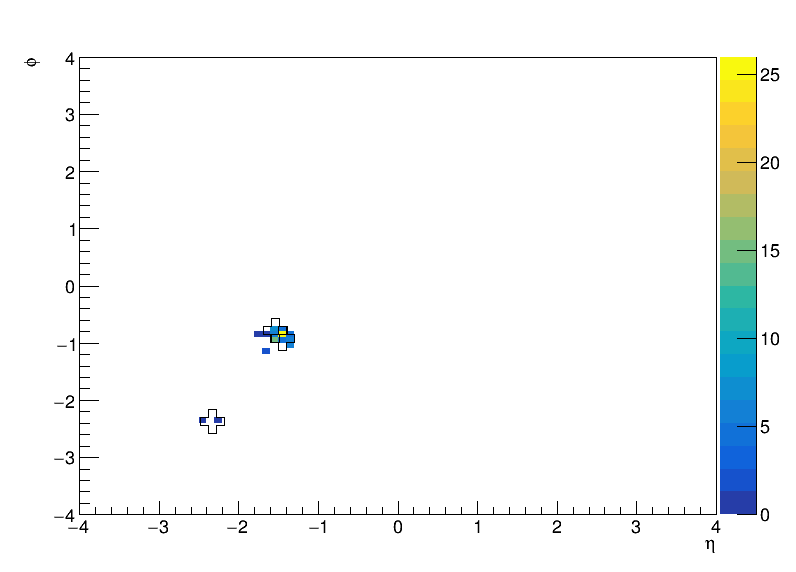

In [97]:
evt_idx = 0

c_cluster = rt.TCanvas('c_cluster','c_cluster', 800, 600)
h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta['m55ct10m_wh_bbbb'][evt_idx],csc_phi['m55ct10m_wh_bbbb'][evt_idx])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])

## Scrapped due to np.logical_and discovery
# Resulting implementation of eventNum
#h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_dis[event4][0],csc_phi_dis[event4][0])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])


c_cluster.SetLogy(0)
h['eta_phi_0'].SetStats(0)
c_cluster.cd()
#h['eta_phi_0'].SetStats(0)
h['eta_phi_0'].Draw("colz")


#test_dataset = np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T

test_dataset = np.vstack((csc_eta['m55ct10m_wh_bbbb'][evt_idx],csc_phi['m55ct10m_wh_bbbb'][evt_idx])).T
#print(test_dataset)
#print test_dataset.ndim
#print len(csc_eta_prompt[evt_idx])
centroids_t,centroid_constituents_t = kmeans(test_dataset,25)
# print(centroids_t)

ll = 0
xx = []
yy = []
nn = 0
for nc in centroid_constituents_t:
    if nc > 0:
        nn += 1
        xx.append(centroids_t[ll,0])
        yy.append(centroids_t[ll,1])
    ll += 1


tg = rt.TGraph(nn)
for ii in range(nn):
    tg.SetPoint(ii,xx[ii],yy[ii])
#     print(xx[ii],yy[ii])


tg.SetMarkerSize(3)
tg.SetMarkerStyle(28)
tg.Draw("P0+same")


c_cluster.Draw()

**=========================================================================================================================================================================**

# Auxiliary Jet/Electron/Muon Variables

## Number of Jets

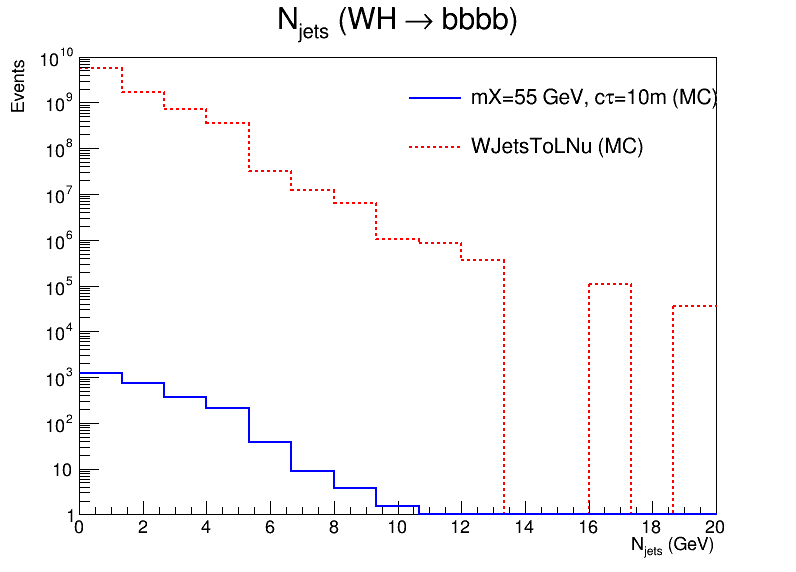

In [101]:
c_njets = rt.TCanvas('c_njets','c_njets', 800, 600)

h['nJets_m55ct10m_wh_bbbb'] = create_TH1D(nJets['m55ct10m_wh_bbbb'], axis_title=['nJets_m55ct10m_wh_bbbb', 'Events'], name='nJets_m55ct10m_wh_bbbb', binning=[15,0,20], weights=weight_m55ct10m)
h['nJets_m55ct10m_wh_bbbb'].SetLineColor(4)

h['nJets_WJetsToLNu'] = create_TH1D(nJets['WJetsToLNu'], axis_title=['nJets_WJetsToLNu', 'Events'], name='nJets_WJetsToLNu', binning=[15,0,20], weights=weight_WJetsToLNu)
h['nJets_WJetsToLNu'].SetLineColor(2)
h['nJets_WJetsToLNu'].SetLineStyle(2)


# h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# h['nCsc_zeroBias_noME11'].SetLineColor(2)
# h['nCsc_zeroBias_noME11'].SetLineStyle(1)

c_njets.SetLogy()

# h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


h['nJets_m55ct10m_wh_bbbb'].SetLineWidth(2)
h['nJets_WJetsToLNu'].SetLineWidth(2)
# h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# h['nJets_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
h['nJets_WJetsToLNu'].GetXaxis().SetRangeUser(0,20)
h['nJets_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


h['nJets_WJetsToLNu'].SetStats(0)
h['nJets_WJetsToLNu'].SetTitle("N_{jets} (WH #rightarrow bbbb)")
h['nJets_WJetsToLNu'].SetXTitle("N_{jets} (GeV)")


h['nJets_WJetsToLNu'].Draw('histo')
h['nJets_m55ct10m_wh_bbbb'].Draw('histo+same')
# h['nCsc_zeroBias_noME11'].Draw('histo+same')

legend = rt.TLegend(0.50,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nJets_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['nJets_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

legend.Draw();

c_njets.Draw()

## Maximum Jet p<sub>T</sub>

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_jetpt


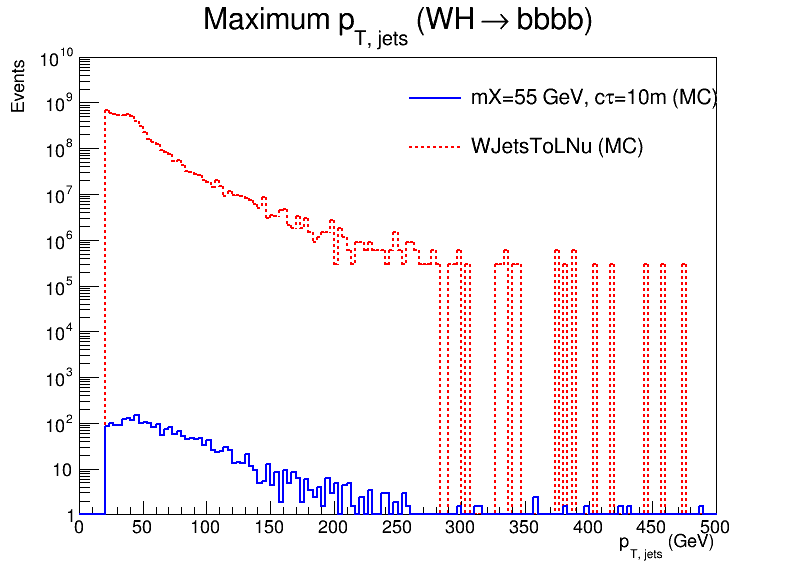

In [360]:
c_jetpt = rt.TCanvas('c_jetpt','c_jetpt', 800, 600)

h['max_jet_pt_m55ct10m_wh_bbbb'] = create_TH1D(max_jet_pt['m55ct10m_wh_bbbb'], axis_title=['max_jet_pt_m55ct10m_wh_bbbb', 'Events'], name='max_jet_pt_m55ct10m_wh_bbbb', binning=[150,0,500], weights=weight_m55ct10m)
h['max_jet_pt_m55ct10m_wh_bbbb'].SetLineColor(4)

h['max_jet_pt_WJetsToLNu'] = create_TH1D(max_jet_pt['WJetsToLNu'], axis_title=['max_jet_pt_WJetsToLNu', 'Events'], name='max_jet_pt_WJetsToLNu', binning=[150,0,500], weights=weight_WJetsToLNu)
h['max_jet_pt_WJetsToLNu'].SetLineColor(2)
h['max_jet_pt_WJetsToLNu'].SetLineStyle(2)


# h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# h['nCsc_zeroBias_noME11'].SetLineColor(2)
# h['nCsc_zeroBias_noME11'].SetLineStyle(1)

c_jetpt.SetLogy()

# h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


h['max_jet_pt_m55ct10m_wh_bbbb'].SetLineWidth(2)
h['max_jet_pt_WJetsToLNu'].SetLineWidth(2)
# h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# h['max_jet_pt_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
h['max_jet_pt_WJetsToLNu'].GetXaxis().SetRangeUser(0,500)
h['max_jet_pt_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


h['max_jet_pt_WJetsToLNu'].SetStats(0)
h['max_jet_pt_WJetsToLNu'].SetTitle("Maximum p_{T, jets} (WH #rightarrow bbbb)")
h['max_jet_pt_WJetsToLNu'].SetXTitle("p_{T, jets} (GeV)")


h['max_jet_pt_WJetsToLNu'].Draw('histo')
h['max_jet_pt_m55ct10m_wh_bbbb'].Draw('histo+same')
# h['nCsc_zeroBias_noME11'].Draw('histo+same')

legend = rt.TLegend(0.50,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['max_jet_pt_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['max_jet_pt_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

legend.Draw();

c_jetpt.Draw()

## MET p<sub>T</sub> Distribution

In [98]:
# c_met = rt.TCanvas('c_met','c_met', 800, 600)

# h['MET_m55ct10m_wh_bbbb'] = create_TH1D(met_pt['m55ct10m_wh_bbbb'], axis_title=['MET_m55ct10m_wh_bbbb', 'Events'], name='MET_m55ct10m_wh_bbbb', binning=[150,0,500])#, weights=weight_m55ct10m)
# h['MET_m55ct10m_wh_bbbb'].SetLineColor(4)

# h['MET_WJetsToLNu'] = create_TH1D(met_pt['WJetsToLNu'], axis_title=['MET_WJetsToLNu', 'Events'], name='MET_WJetsToLNu', binning=[150,0,500])#, weights=weight_WJetsToLNu)
# h['MET_WJetsToLNu'].SetLineColor(2)
# h['MET_WJetsToLNu'].SetLineStyle(2)


# # h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# # h['nCsc_zeroBias_noME11'].SetLineColor(2)
# # h['nCsc_zeroBias_noME11'].SetLineStyle(1)

# c_met.SetLogy()

# h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# # h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


# h['MET_m55ct10m_wh_bbbb'].SetLineWidth(2)
# h['MET_WJetsToLNu'].SetLineWidth(2)
# # h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# h['MET_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
# h['MET_WJetsToLNu'].GetXaxis().SetRangeUser(0,500)
# # h['MET_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


# h['MET_WJetsToLNu'].SetStats(0)
# h['MET_WJetsToLNu'].SetTitle("MET p_{T} (WH #rightarrow bbbb)")
# h['MET_WJetsToLNu'].SetXTitle("MET p_{T} (GeV)")


# h['MET_WJetsToLNu'].Draw('histo')
# h['MET_m55ct10m_wh_bbbb'].Draw('histo+same')
# # h['nCsc_zeroBias_noME11'].Draw('histo+same')

# legend = rt.TLegend(0.50,0.70,0.87,0.87);
# legend.SetTextSize(0.04);
# legend.SetBorderSize(0);
# #legend-.SetFillStyle(0);
# legend.AddEntry( h['MET_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
# legend.AddEntry( h['MET_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# # legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

# legend.Draw();

# c_met.Draw()

## Number of Muons

In [100]:
# c_nmu = rt.TCanvas('c_nmu','c_nmu', 800, 600)

# h['nMu_m55ct10m_wh_bbbb'] = create_TH1D(nMuons['m55ct10m_wh_bbbb'], axis_title=['nMu_m55ct10m_wh_bbbb', 'Events'], name='nMu_m55ct10m_wh_bbbb', binning=[15,0,20], weights=weight_m55ct10m)
# h['nMu_m55ct10m_wh_bbbb'].SetLineColor(4)

# h['nMu_WJetsToLNu'] = create_TH1D(nMuons['WJetsToLNu'], axis_title=['nMu_WJetsToLNu', 'Events'], name='nMu_WJetsToLNu', binning=[15,0,20], weights=weight_WJetsToLNu)
# h['nMu_WJetsToLNu'].SetLineColor(2)
# h['nMu_WJetsToLNu'].SetLineStyle(2)


# # h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# # h['nCsc_zeroBias_noME11'].SetLineColor(2)
# # h['nCsc_zeroBias_noME11'].SetLineStyle(1)

# c_nmu.SetLogy()

# # h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# # h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# # h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


# h['nMu_m55ct10m_wh_bbbb'].SetLineWidth(2)
# h['nMu_WJetsToLNu'].SetLineWidth(2)
# # h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# # h['nMu_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
# h['nMu_WJetsToLNu'].GetXaxis().SetRangeUser(0,20)
# h['nMu_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


# h['nMu_WJetsToLNu'].SetStats(0)
# h['nMu_WJetsToLNu'].SetTitle("N_{#mu} (WH #rightarrow bbbb)")
# h['nMu_WJetsToLNu'].SetXTitle("N_{#mu} (GeV)")


# h['nMu_WJetsToLNu'].Draw('histo')
# h['nMu_m55ct10m_wh_bbbb'].Draw('histo+same')
# # h['nCsc_zeroBias_noME11'].Draw('histo+same')

# legend = rt.TLegend(0.50,0.70,0.87,0.87);
# legend.SetTextSize(0.04);
# legend.SetBorderSize(0);
# #legend-.SetFillStyle(0);
# legend.AddEntry( h['nMu_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
# legend.AddEntry( h['nMu_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# # legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

# legend.Draw();

# c_nmu.Draw()

## Maximum Muon p<sub>T</sub>

In [361]:
# c_muonpt = rt.TCanvas('c_muonpt','c_muonpt', 800, 600)

# h['max_muon_pt_m55ct10m_wh_bbbb'] = create_TH1D(max_mu_pt['m55ct10m_wh_bbbb'], axis_title=['max_muon_pt_m55ct10m_wh_bbbb', 'Events'], name='max_muon_pt_m55ct10m_wh_bbbb', binning=[150,0,500], weights=weight_m55ct10m)
# h['max_muon_pt_m55ct10m_wh_bbbb'].SetLineColor(4)

# h['max_muon_pt_WJetsToLNu'] = create_TH1D(max_mu_pt['WJetsToLNu'], axis_title=['max_muon_pt_WJetsToLNu', 'Events'], name='max_muon_pt_WJetsToLNu', binning=[150,0,500], weights=weight_WJetsToLNu)
# h['max_muon_pt_WJetsToLNu'].SetLineColor(2)
# h['max_muon_pt_WJetsToLNu'].SetLineStyle(2)


# # h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# # h['nCsc_zeroBias_noME11'].SetLineColor(2)
# # h['nCsc_zeroBias_noME11'].SetLineStyle(1)

# c_muonpt.SetLogy()

# # h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# # h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# # h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


# h['max_muon_pt_m55ct10m_wh_bbbb'].SetLineWidth(2)
# h['max_muon_pt_WJetsToLNu'].SetLineWidth(2)
# # h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# # h['max_muon_pt_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
# h['max_muon_pt_WJetsToLNu'].GetXaxis().SetRangeUser(0,500)
# h['max_muon_pt_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


# h['max_muon_pt_WJetsToLNu'].SetStats(0)
# h['max_muon_pt_WJetsToLNu'].SetTitle("Maximum p_{T, #mu} (WH #rightarrow bbbb)")
# h['max_muon_pt_WJetsToLNu'].SetXTitle("p_{T, #mu} (GeV)")


# h['max_muon_pt_WJetsToLNu'].Draw('histo')
# h['max_muon_pt_m55ct10m_wh_bbbb'].Draw('histo+same')
# # h['nCsc_zeroBias_noME11'].Draw('histo+same')

# legend = rt.TLegend(0.50,0.70,0.87,0.87);
# legend.SetTextSize(0.04);
# legend.SetBorderSize(0);
# #legend-.SetFillStyle(0);
# legend.AddEntry( h['max_muon_pt_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
# legend.AddEntry( h['max_muon_pt_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# # legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

# legend.Draw();

# c_muonpt.Draw()

## Maximum Electron p<sub>T</sub>

In [362]:
# c_elept = rt.TCanvas('c_elept','c_elept', 800, 600)

# h['max_ele_pt_m55ct10m_wh_bbbb'] = create_TH1D(max_ele_pt['m55ct10m_wh_bbbb'], axis_title=['max_ele_pt_m55ct10m_wh_bbbb', 'Events'], name='max_ele_pt_m55ct10m_wh_bbbb', binning=[150,0,500], weights=weight_m55ct10m)
# h['max_ele_pt_m55ct10m_wh_bbbb'].SetLineColor(4)

# h['max_ele_pt_WJetsToLNu'] = create_TH1D(max_ele_pt['WJetsToLNu'], axis_title=['max_ele_pt_WJetsToLNu', 'Events'], name='max_ele_pt_WJetsToLNu', binning=[150,0,500], weights=weight_WJetsToLNu)
# h['max_ele_pt_WJetsToLNu'].SetLineColor(2)
# h['max_ele_pt_WJetsToLNu'].SetLineStyle(2)


# # h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
# # h['nCsc_zeroBias_noME11'].SetLineColor(2)
# # h['nCsc_zeroBias_noME11'].SetLineStyle(1)

# c_elept.SetLogy()

# # h['MET_m55ct10m_wh_bbbb'].Scale(1.0/h['MET_m55ct10m_wh_bbbb'].Integral())
# # h['MET_WJetsToLNu'].Scale(1.0/h['MET_WJetsToLNu'].Integral())
# # h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


# h['max_ele_pt_m55ct10m_wh_bbbb'].SetLineWidth(2)
# h['max_ele_pt_WJetsToLNu'].SetLineWidth(2)
# # h['nCsc_zeroBias_noME11'].SetLineWidth(2)

# # h['max_ele_pt_m55ct10m_wh_bbbb'].GetXaxis().SetRangeUser(0,500)
# h['max_ele_pt_WJetsToLNu'].GetXaxis().SetRangeUser(0,500)
# h['max_ele_pt_WJetsToLNu'].GetYaxis().SetRangeUser(1, 10**10)


# h['max_ele_pt_WJetsToLNu'].SetStats(0)
# h['max_ele_pt_WJetsToLNu'].SetTitle("Maximum p_{T, electron} (WH #rightarrow bbbb)")
# h['max_ele_pt_WJetsToLNu'].SetXTitle("p_{T, electron} (GeV)")


# h['max_ele_pt_WJetsToLNu'].Draw('histo')
# h['max_ele_pt_m55ct10m_wh_bbbb'].Draw('histo+same')
# # h['nCsc_zeroBias_noME11'].Draw('histo+same')

# legend = rt.TLegend(0.50,0.70,0.87,0.87);
# legend.SetTextSize(0.04);
# legend.SetBorderSize(0);
# #legend-.SetFillStyle(0);
# legend.AddEntry( h['max_ele_pt_m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
# legend.AddEntry( h['max_ele_pt_WJetsToLNu'], "WJetsToLNu (MC)" , "L");
# # legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

# legend.Draw();

# c_elept.Draw()

# Backup Clustering: k-means

In [134]:
n_c_total = {}
n_c_hits_12 = {}
n_c_hits_13 = {}

delta_t_max_freq = {}
delta_t_max = {}

# met_pt_cluster = {}
# delta_t_average = {}

def sel_clustering(station, model): # Add (, model) for gen level info
        eta_data_sel = data_sel[station][0]
        t_data_sel = data_sel[station][1]
        z_data_sel = data_sel[station][2]
        if station == 2 or station == -2:
            x_data_sel = data_sel[station][3]
            y_data_sel = data_sel[station][4]
        else:
            x_data_sel = np.zeros(len(eta_data_sel))
            y_data_sel = np.zeros(len(eta_data_sel))
            
        test_dataset = np.vstack((eta_data_sel, t_data_sel)).T
        
        # Centroid_constituents is a list of all of the hits corresponding to each centroid
        # etaPhi_labels is a list of the centroids corresponding to each hit
        centroids, centroid_constituents = kmeans(test_dataset, 25)
#         centroids, centroid_constituents = kmedians(test_dataset, 25)
        etaPhi_labels = getLabels(test_dataset, centroids, 2)
        
#         print(centroid_constituents)
#         print(etaPhi_labels)
        
        # Determines nCsc for all clusters
        total_hits = 0
#         met_val = 0
        for cc in centroid_constituents:
            if cc > 3:
                total_hits += cc
#                 met_val += 
        
        n_c_total[data_type][station].append(total_hits)
        
        # Separates and counts hits in ME 1/2 and ME 1/3
        z_final = np.array([])
        t_final = np.array([])
        r_final_123_sel = np.array([])
        cluster_freq = np.array([])
        for cluster in np.unique(etaPhi_labels):
            if np.count_nonzero(etaPhi_labels == cluster) > 3:
                if cluster != 0:
                    z_final = np.append(z_final, z_data_sel[etaPhi_labels == cluster])
                    x_final_123_sel = x_data_sel[etaPhi_labels == cluster]
                    y_final_123_sel = y_data_sel[etaPhi_labels == cluster]
                    r_final_123_sel = np.append(r_final_123_sel, np.sqrt(x_final_123_sel**2+y_final_123_sel**2))
                    cluster_freq = np.append(cluster_freq, centroid_constituents[cluster])
                    t_final = np.append(t_final, t_data_sel[etaPhi_labels == cluster])
                

        if t_final.shape[0] == 0:
#             t_final = np.append(t_final, np.nan)
            delta_t_max[data_type][station].append(np.nan)
            delta_t_max_freq[data_type][station].append(np.nan)
            
        else:
            max_cluster_freq = np.amax(cluster_freq)
            delta_t_max_freq[data_type][station].append(max_cluster_freq)
            t_cluster = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])]
            if len(t_cluster) != 0:
                if etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])][0] != 0:
#                     max_t = np.max(t_cluster)
#                     min_t = np.min(t_cluster)
                    delta_t = np.mean(t_cluster)
                    delta_t_max[data_type][station].append(delta_t)
                    
                else:
                    t_cluster_prime = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])]
#                     max_t = np.max(t_cluster_prime)
#                     min_t = np.min(t_cluster_prime)
                    delta_t = np.mean(t_cluster)
                    delta_t_max[data_type][station].append(delta_t)
#                     if delta_t > 1:
# #                         print(max_t)
# #                         print(min_t)
#                         print(etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][0])])
#                         print(etaPhi_labels[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])])
#                         print(max_cluster_freq)
#                         print(etaPhi_labels)
            else:
                t_cluster_prime = t_data_sel[np.where(etaPhi_labels == np.where(centroid_constituents == max_cluster_freq)[0][1])]
                max_t = np.max(t_cluster_prime)
                min_t = np.min(t_cluster_prime)
                delta_t = np.mean(t_cluster)
                delta_t_max[data_type][station].append(delta_t)

        
        if r_final_123_sel.shape[0] == 0:
            n_c_hits_12[data_type][station].append(0.0)
            n_c_hits_13[data_type][station].append(0.0)
        else:
            sel_counter_12 = 0
            sel_counter_13 = 0
            for hit_r in r_final_123_sel:
                if hit_r < 465 and hit_r > 275:
                    sel_counter_12 += 1
                if hit_r < 695.5 and hit_r > 505.5:
                    sel_counter_13 += 1
            n_c_hits_12[data_type][station].append(sel_counter_12)
            n_c_hits_13[data_type][station].append(sel_counter_13)
#         print(t_data_sel)
#         if t_final.shape[0] == 0:
#             delta_t_max[data_type][station].append(0.0)
#             delta_t_average[data_type][station].append(0.0)
#         else:
#             if np.absolute(np.amax(t_final)) > np.absolute(np.amin(t_final)):
#                 delta_t_max[data_type][station].append(np.amax(t_final))
#             else:
#                 delta_t_max[data_type][station].append(np.amin(t_final))
#             delta_t_average[data_type][station].append(np.sum(t_final)/len(t_final))

In [ ]:
print('Start: '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
for data_type in data_trees.keys():
    n_c_total[data_type] = {}
    n_c_total[data_type]['total'] = []
    
    delta_t_max[data_type] = {}
    delta_t_max[data_type]['total'] = []
    
    delta_t_max_freq[data_type] = {}

#     delta_t_average[data_type] = {}
#     delta_t_average[data_type]['total'] = []
    
    n_c_hits_12[data_type] = {}
    n_c_hits_13[data_type] = {}

    csc_sections = [1,2,3,4,5, -1, -2, -3, -4, -5]
    for section in csc_sections:
        n_c_total[data_type][section] = []
        n_c_hits_12[data_type][section] = []
        n_c_hits_13[data_type][section] = []
        
        delta_t_max[data_type][section] = []
        delta_t_max_freq[data_type][section] = []
        
#         delta_t_average[data_type][section] = []

            
    for sel_event in range(csc_eta[data_type].shape[0]):

        data_sel = {}

        # 1/1 if 568 < zPos < 632:
        hits_pos1_sel = np.logical_and(csc_z[data_type][sel_event]<632, csc_z[data_type][sel_event]>568)
        hits_neg1_sel = np.logical_and(csc_z[data_type][sel_event]>-632, csc_z[data_type][sel_event]<-568)
        data_sel[1] = (csc_eta[data_type][sel_event][hits_pos1_sel], csc_t[data_type][sel_event][hits_pos1_sel], csc_z[data_type][sel_event][hits_pos1_sel])
        data_sel[-1] = (csc_eta[data_type][sel_event][hits_neg1_sel], csc_t[data_type][sel_event][hits_neg1_sel], csc_z[data_type][sel_event][hits_neg1_sel])


        # 1/2 and 1/3 elif 663 < zPos < 724:
        hits_pos2_sel = np.logical_and(csc_z[data_type][sel_event]<724, csc_z[data_type][sel_event]>663)
        hits_neg2_sel = np.logical_and(csc_z[data_type][sel_event]>-724, csc_z[data_type][sel_event]<-663)
        data_sel[2] = (csc_eta[data_type][sel_event][hits_pos2_sel], csc_t[data_type][sel_event][hits_pos2_sel], csc_z[data_type][sel_event][hits_pos2_sel], csc_x[data_type][sel_event][hits_pos2_sel], csc_y[data_type][sel_event][hits_pos2_sel])
        data_sel[-2] = (csc_eta[data_type][sel_event][hits_neg2_sel], csc_t[data_type][sel_event][hits_neg2_sel], csc_z[data_type][sel_event][hits_neg2_sel], csc_x[data_type][sel_event][hits_neg2_sel], csc_y[data_type][sel_event][hits_neg2_sel])


        # 2/1 and 2/2 elif 791 < zPos < 849.5:
        hits_pos3_sel = np.logical_and(csc_z[data_type][sel_event]<849.5, csc_z[data_type][sel_event]>791)
        hits_neg3_sel = np.logical_and(csc_z[data_type][sel_event]>-849.5, csc_z[data_type][sel_event]<-791)
        data_sel[3] = (csc_eta[data_type][sel_event][hits_pos3_sel], csc_t[data_type][sel_event][hits_pos3_sel], csc_z[data_type][sel_event][hits_pos3_sel])
        data_sel[-3] = (csc_eta[data_type][sel_event][hits_neg3_sel], csc_t[data_type][sel_event][hits_neg3_sel], csc_z[data_type][sel_event][hits_neg3_sel])


        # 3/1 and 3/2 elif 911.5 < zPos < 970:
        hits_pos4_sel = np.logical_and(csc_z[data_type][sel_event]<970, csc_z[data_type][sel_event]>911.5)
        hits_neg4_sel = np.logical_and(csc_z[data_type][sel_event]>-970, csc_z[data_type][sel_event]<-911.5)
        data_sel[4] = (csc_eta[data_type][sel_event][hits_pos4_sel], csc_t[data_type][sel_event][hits_pos4_sel], csc_z[data_type][sel_event][hits_pos4_sel])
        data_sel[-4] = (csc_eta[data_type][sel_event][hits_neg4_sel], csc_t[data_type][sel_event][hits_neg4_sel], csc_z[data_type][sel_event][hits_neg4_sel])


        # 4/1 and 4/2 elif 1002 < zPos < 1060.5:
        hits_pos5_sel = np.logical_and(csc_z[data_type][sel_event]<1060.5, csc_z[data_type][sel_event]>1002.5)
        hits_neg5_sel = np.logical_and(csc_z[data_type][sel_event]>-1060.5, csc_z[data_type][sel_event]<-1002.5)
        data_sel[5] = (csc_eta[data_type][sel_event][hits_pos5_sel], csc_t[data_type][sel_event][hits_pos5_sel], csc_z[data_type][sel_event][hits_pos5_sel])
        data_sel[-5] = (csc_eta[data_type][sel_event][hits_neg5_sel], csc_t[data_type][sel_event][hits_neg5_sel], csc_z[data_type][sel_event][hits_neg5_sel])

        sel_clustering(1, data_type)
        sel_clustering(-1, data_type)
        sel_clustering(2, data_type)
        sel_clustering(-2, data_type)
        sel_clustering(3, data_type)
        sel_clustering(-3, data_type)
        sel_clustering(4, data_type)
        sel_clustering(-4, data_type)
        sel_clustering(5, data_type)
        sel_clustering(-5, data_type)

        ncsc_temp = 0.0
        t_max_temp = np.array([])
        t_freq_temp = []
        
        for x in csc_sections:
            ncsc_temp += n_c_total[data_type][x][-1]
            t_freq_temp.append(delta_t_max_freq[data_type][x][-1])
            t_max_temp = np.append(t_max_temp, delta_t_max[data_type][x][-1])


        n_c_total[data_type]['total'].append(ncsc_temp)
        
        if len(t_freq_temp) == len(csc_sections):
            t_freq_temp = np.nan_to_num(t_freq_temp).astype(int)
            max_freq = np.amax(t_freq_temp)
            max_freq_index = np.where(t_freq_temp == max_freq)
#             print(t_max_temp[max_freq_index][0])
#             if np.absolute(np.amax(t_max_temp[max_freq_index])) > np.absolute(np.amin(t_max_temp[max_freq_index])):
#                 max_delT = np.amax(t_max_temp[max_freq_index])
#             else:
#                 max_delT = np.amin(t_max_temp[max_freq_index])
                
            delta_t_max[data_type]['total'].append(t_max_temp[max_freq_index][0])
            
#             if len((t_max_temp[max_freq_index])) != len(csc_sections):
#                 if np.absolute(np.amax(t_max_temp[max_freq_index])) > np.absolute(np.amin(t_max_temp[max_freq_index])):
#                     max_delPhi = np.amax(t_max_temp[max_freq_index])
#                 else:
#                     max_delPhi = np.amin(t_max_temp[max_freq_index])
#                 delta_t_max[data_type]['total'].append(max_delPhi)
#             else:
#                 delta_t_max[data_type]['total'].append(np.nan)
        else:
            print("Function error")
        
        # 310000
#         if sel_event > 40000:
#             break
            
#         if np.absolute(np.amax(t_avg_temp)) > np.absolute(np.amin(t_avg_temp)):
#             delta_t_max[data_type]['total'].append(np.amax(t_avg_temp))
#         else:
#             delta_t_max[data_type]['total'].append(np.amin(t_avg_temp))
            
#         delta_t_average[data_type]['total'].append(np.sum(t_avg_temp)/len(t_avg_temp))        
#         break
        
    print(data_type + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [ ]:
nCsc_cluster = {}
for data_type in data_trees.keys():
    nCsc_cluster[data_type] = {}
    nCsc_cluster[data_type]['csc_inclusive'] = np.array(n_c_total[data_type]['total'])
    nCsc_cluster[data_type]['csc_noME11'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]))
    nCsc_cluster[data_type]['csc_noME112'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]) + np.array(n_c_hits_12[data_type][2]) + np.array(n_c_hits_12[data_type][-2]))
    nCsc_cluster[data_type]['csc_noME1123'] = np.array(n_c_total[data_type]['total']) - (np.array(n_c_total[data_type][1]) + np.array(n_c_total[data_type][-1]) + np.array(n_c_total[data_type][2]) + np.array(n_c_total[data_type][-2]))

In [ ]:
n_c_total['m55ct10m_wh_bbbb'] = {}
nCsc_cluster['m55ct10m_wh_bbbb'] = {}
for llave in n_c_total['m55ct10m_wh_bbbb_minus'].keys():
    n_c_total['m55ct10m_wh_bbbb'][llave] = np.concatenate([n_c_total['m55ct10m_wh_bbbb_minus'][llave], n_c_total['m55ct10m_wh_bbbb_plus'][llave]])
for cle in nCsc_cluster['m55ct10m_wh_bbbb_minus'].keys():
#     nCsc_cluster['m55ct10m_wh_bbbb'][cle] = {}
#     for kagi in nCsc_cluster['m55ct10m_wh_bbbb'][cle].keys():
    
    nCsc_cluster['m55ct10m_wh_bbbb'][cle] = np.concatenate([nCsc_cluster['m55ct10m_wh_bbbb_minus'][cle], nCsc_cluster['m55ct10m_wh_bbbb_plus'][cle]])